In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import readligo as rl
from gwpy.timeseries import TimeSeries
import math
import random

In [2]:
epochs = 400
test_sample_ratio = .2
validation_sample_ratio = 0.1
input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 0

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [4]:
def normalize(v):
    norm = np.linalg.norm(v)
    junk = 0
    if norm == 0: 
       return v, junk, norm
    return v / norm, junk, norm

In [5]:
def bunch_normalization(v_set):
    recover_min = list(range(len(v_set)))
    recover_coef = list(range(len(v_set)))
    v_set_normalized = np.zeros((v_set.shape[0], v_set.shape[1]))
    for i in range(len(v_set)):
        v_set_normalized[i], recover_min[i], recover_coef[i] = normalize(v_set[i])
    return v_set_normalized, recover_min, recover_coef

In [205]:
def TPR_calculation(noise_distribution, signal_distribution, FPR):
    threshold_rank = len(noise_distribution) * FPR
    threshold = np.partition(noise_distribution, -threshold_rank)[-threshold_rank]
    
    TPR = np.argwhere(signal_distribution > threshold).shape[0] / len(signal_distribution)
    
    return TPR

In [35]:
data_for_training_and_testing = np.load("../Data_cached/4000Hz25msnoisesample.npy") * 1e21

In [30]:
data_injected = np.delete(np.load("../Data_cached/4000Hz25msdatasampleBBH.npy") * 1e21, 47, axis = 0)

In [43]:
data_injected = np.load("../Data_cached/4000Hz25msdatasampleBBH3346.npy") * 1e21

In [9]:
np.linalg.norm(data_injected, axis = 1).mean()

1.958889740529385

In [10]:
max(np.linalg.norm(data_for_training_and_testing, axis = 1))

0.42085477733884324

In [44]:
data_injected = data_injected / max(np.linalg.norm(data_injected, axis = 1))

In [45]:
max(np.linalg.norm(data_injected, axis = 1))

0.9999999999999999

In [13]:
np.linalg.norm(data_injected, axis = 1).mean()

0.25265261122680854

Text(0, 0.5, 'Strain')

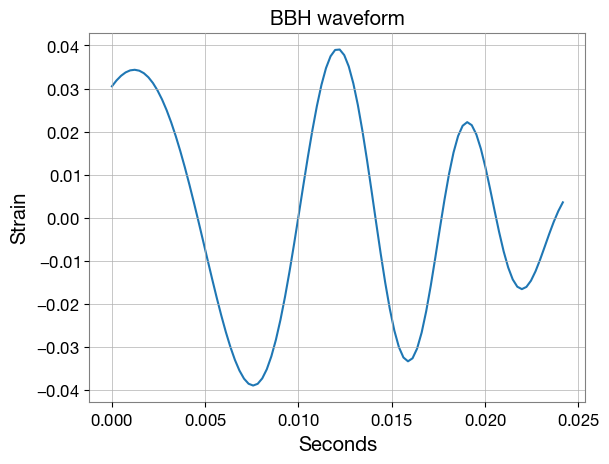

In [33]:
plt.plot(np.arange(0,100/4096, 1/4096), data_injected[0])
plt.title('BBH waveform')
plt.xlabel('Seconds')
plt.ylabel('Strain')

Text(0, 0.5, 'Strain')

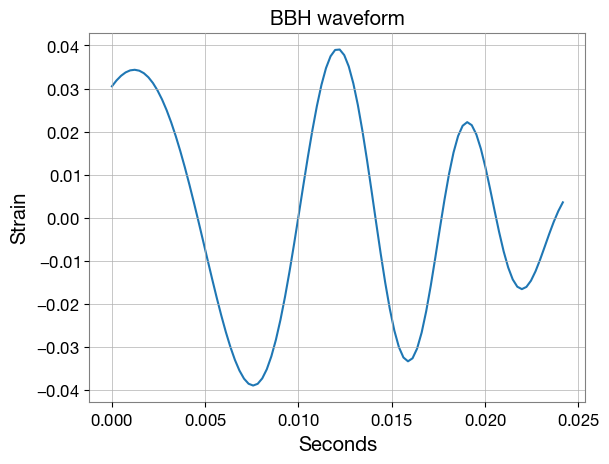

In [13]:
plt.plot(np.arange(0,100/4096, 1/4096), data_injected[0])
plt.title('BBH waveform')
plt.xlabel('Seconds')
plt.ylabel('Strain')

Text(0, 0.5, 'Strain')

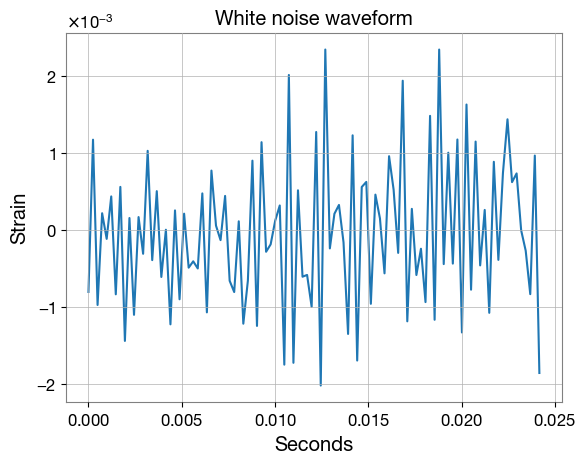

In [14]:
plt.plot(np.arange(0,100/4096, 1/4096), data_for_training_and_testing[0])
plt.title('White noise waveform')
plt.xlabel('Seconds')
plt.ylabel('Strain')

In [46]:
total_sample_number = data_for_training_and_testing.shape[0]
test_sample_number = int(test_sample_ratio * total_sample_number)
validation_sample_number = int(validation_sample_ratio * total_sample_number)
train_sample_number = total_sample_number - test_sample_number - validation_sample_number


X_train_ini = data_for_training_and_testing[0:train_sample_number].copy()
X_test_ini = data_for_training_and_testing[-test_sample_number:].copy()
X_validation_ini = data_for_training_and_testing[train_sample_number:-test_sample_number].copy()

In [151]:
np.linalg.norm(X_train_ini, axis = 1).mean()

0.3289918823749865

In [390]:
train_glitch_sample = np.load("../Data_cached/glitch_data_clean_25ms.npy")

In [391]:
train_glitch_sample_modified = np.delete(train_glitch_sample, np.linalg.norm(train_glitch_sample, axis = 1) > 10, axis = 0)

In [394]:
np.mean(np.linalg.norm(train_glitch_sample_modified, axis = 1))

0.6420515040927467

In [393]:
train_glitch_sample_modified = train_glitch_sample_modified / max(np.linalg.norm(train_glitch_sample_modified, axis = 1))

In [435]:
train_glitch_sample_modified_cut_500 = train_glitch_sample_modified[0:500]
train_glitch_sample_modified_cut_test = train_glitch_sample_modified[500:-1]

In [436]:
glitched_noise_number = len(train_glitch_sample_modified_cut_500)
size_test = int(glitched_noise_number * test_sample_ratio)
size_validation = int(glitched_noise_number * validation_sample_ratio)
size_train = glitched_noise_number - size_test - size_validation

In [437]:
random_integers = np.random.choice(range(7000), size=size_train, replace=False)

In [438]:
random_integers_2 = np.random.choice(range(2000), size=size_test, replace=False)

In [439]:
random_integers_3 = np.random.choice(range(1000), size=size_validation, replace=False)

In [342]:
random_integers_3

array([597, 735, 796, 100, 823, 376, 491, 603, 255,  59, 260,
        49, 400, 431, 967, 319, 737, 352, 127, 394,  57, 317,
       773, 428,  68, 475, 718,  56, 426, 787, 896, 396, 701,
       783, 451, 920, 137, 468, 584, 542, 804,  41, 253,  80,
       121, 629, 241, 919, 877, 351, 417, 522, 439, 266, 621,
       507,  71,  37, 665,   4, 761, 678, 994, 997,  78, 514,
       140, 570, 427])

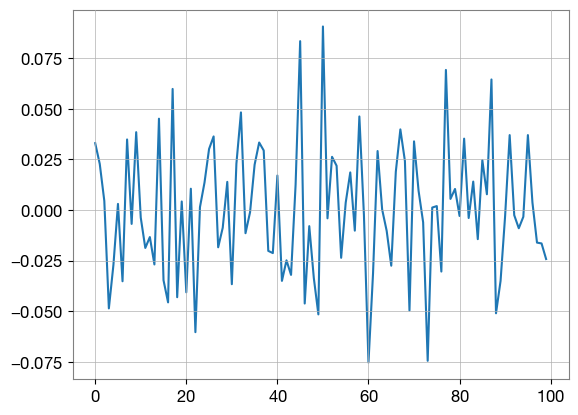

In [124]:
plt.plot(X_validation_ini[181])

In [443]:
random_integers_3.shape

(50,)

In [440]:
X_train_replaced = X_train_ini.copy()
X_train_replaced[random_integers] = train_glitch_sample_modified_cut_500[0:size_train]

In [441]:
X_test_replaced = X_test_ini.copy()
X_test_replaced[random_integers_2] = train_glitch_sample_modified_cut_500[-size_test:glitched_noise_number + 1]

In [442]:
X_validation_replaced = X_validation_ini.copy()
X_validation_replaced[random_integers_3] = train_glitch_sample_modified_cut_500[size_train:-size_test]

In [406]:
X_validation_replaced.shape

(1000, 100)

In [350]:
# X_train, X_train_recover_min, X_train_recover_coef = bunch_normalization(X_train_replaced)
# X_test, X_test_recover_min, X_test_recover_coef = bunch_normalization(X_test_replaced)
# X_validation, X_validation_recover_min, X_validation_recover_coef = bunch_normalization(X_validation_replaced)
# data_injected_normalized, junk1, junk2 = bunch_normalization(data_injected.copy())

In [407]:
X_train, X_train_recover_min, X_train_recover_coef = bunch_normalization(X_train_ini)
X_test, X_test_recover_min, X_test_recover_coef = bunch_normalization(X_test_ini)
X_validation, X_validation_recover_min, X_validation_recover_coef = bunch_normalization(X_validation_ini)
data_injected_normalized, junk1, junk2 = bunch_normalization(data_injected.copy())

In [408]:
X_train = np.hstack((X_train, np.array(X_train_recover_coef).reshape(train_sample_number,1)))
X_validation = np.hstack((X_validation, np.array(X_validation_recover_coef).reshape(validation_sample_number,1)))
X_test = np.hstack((X_test, np.array(X_test_recover_coef).reshape(test_sample_number,1)))
data_injected_normalized = np.hstack((data_injected_normalized, np.array(junk2).reshape(len(data_injected),1)))

In [45]:
# X_train = np.hstack((X_train, np.ones((train_sample_number, 1))))
# X_validation = np.hstack((X_validation, np.ones((validation_sample_number, 1))))
# X_test = np.hstack((X_test, np.ones((test_sample_number, 1))))
# data_injected_normalized = np.hstack((data_injected_normalized, np.ones((len(data_injected), 1))))

In [409]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

In [444]:
train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)


autoencoder = AutoEncoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))


for epoch in range(epochs):
    # 训练阶段
    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        loss_norm = loss_func(decoded[:, -1], x[:, -1])
        weighted_lossTrain = loss_overall + loss_norm * coef_delta
        
        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term
        
        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    # 验证阶段
    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall + lossVal_norm * coef_delta
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)
    
    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
    print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

Epoch: 0001, Training loss=0.02545499, Validation loss=0.02555401
Epoch: 0002, Training loss=0.02164544, Validation loss=0.02194959
Epoch: 0003, Training loss=0.01875199, Validation loss=0.01858812
Epoch: 0004, Training loss=0.01613580, Validation loss=0.01558915
Epoch: 0005, Training loss=0.01326031, Validation loss=0.01315365
Epoch: 0006, Training loss=0.01158115, Validation loss=0.01144205
Epoch: 0007, Training loss=0.01027138, Validation loss=0.01041308
Epoch: 0008, Training loss=0.00989091, Validation loss=0.00983231
Epoch: 0009, Training loss=0.00976599, Validation loss=0.00950322
Epoch: 0010, Training loss=0.00939256, Validation loss=0.00931247
Epoch: 0011, Training loss=0.00927926, Validation loss=0.00916466
Epoch: 0012, Training loss=0.00894445, Validation loss=0.00903188
Epoch: 0013, Training loss=0.00892259, Validation loss=0.00892730
Epoch: 0014, Training loss=0.00871412, Validation loss=0.00882168
Epoch: 0015, Training loss=0.00875552, Validation loss=0.00873078
Epoch: 001

In [445]:
torch.save(autoencoder, '../Model_cached/model_101_20_101_0_glitchesinjected_cut_5%.pt')

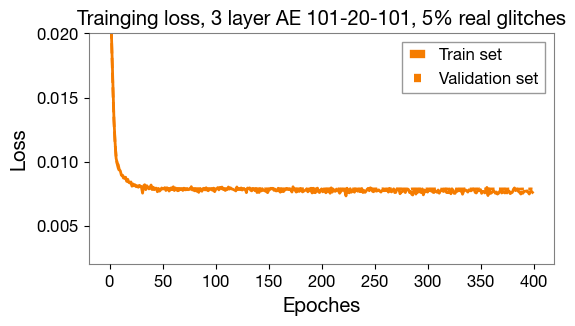

In [446]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 3 layer AE 101-20-101, 5% real glitches')
plt.ylim(0.002,0.02)
plt.legend()
plt.show()

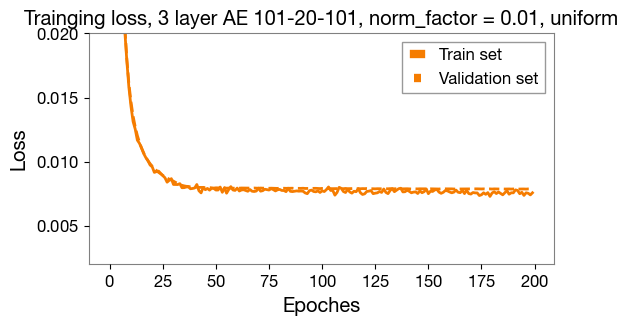

In [17]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 3 layer AE 101-20-101, norm_factor = 0.01, uniform')
plt.ylim(0.002,0.02)
plt.legend()
plt.show()

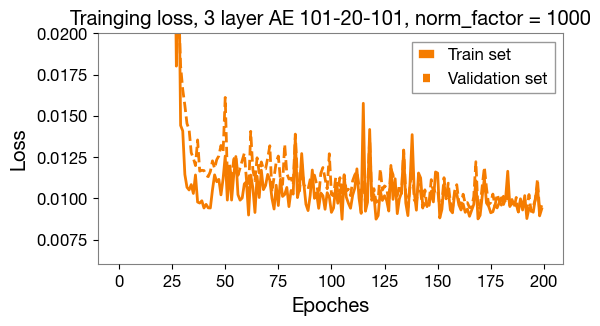

In [103]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 3 layer AE 101-20-101, norm_factor = 1000')
plt.ylim(0.006,0.02)
plt.legend()
plt.show()

In [447]:
_, decodedTestdata = autoencoder(trainData)
decodedTestdata = decodedTestdata.double()
reconstructedData_train = decodedTestdata.detach().numpy()
ReconstructedError_train = torch.mean((trainData - reconstructedData_train)**2,dim=1)
MSE_train = ReconstructedError_train.mean()

In [191]:
X_train_output = X_train[:, :100]
reconstructedData_train_output = reconstructedData_train[:, :100]

Text(0, 0.5, 'Strain')

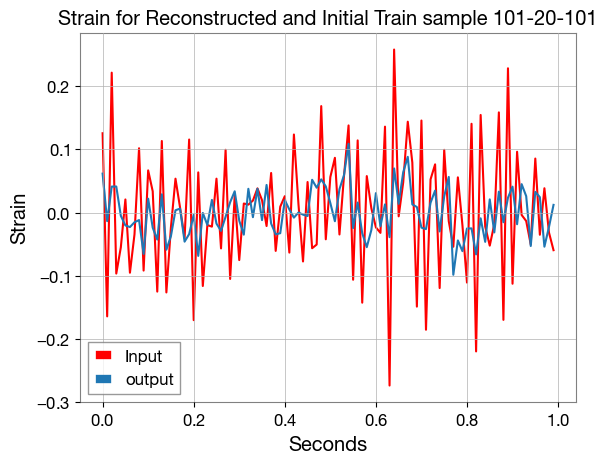

In [92]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,1,1/100)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_train_output


plt.plot(x, X_train_output[3].flatten(), color = 'red', label = 'Input')
plt.plot(x, y[3].flatten(), label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial Train sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

Text(0, 0.5, 'Strain')

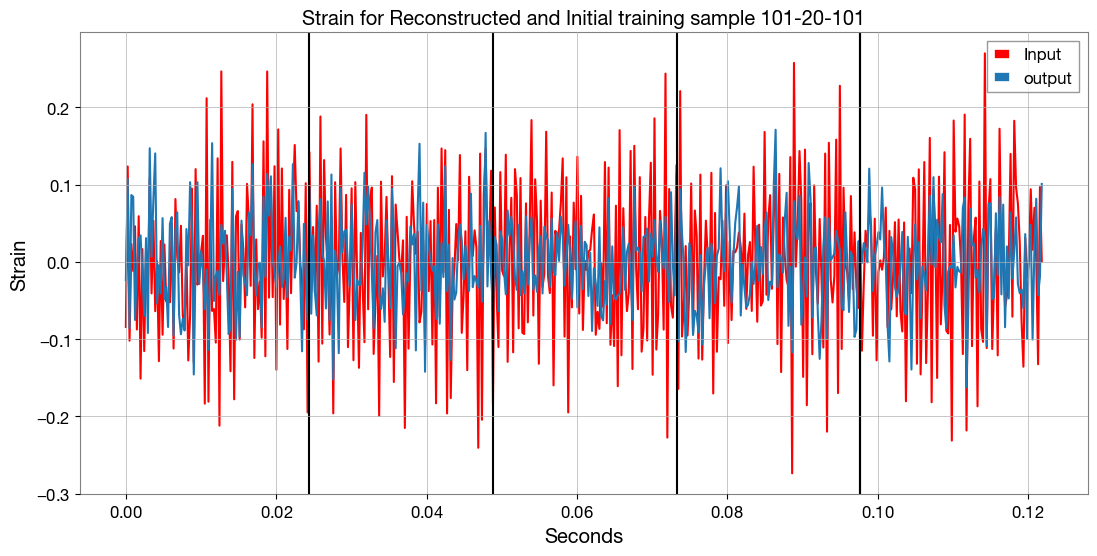

In [24]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,500/4096,1/4096)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_train_output

plt.figure(figsize=(13,6))
plt.plot(x, X_train_output.flatten()[0:500], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:500], label = 'output')
plt.axvline(x = 100/4096, color = 'black')
plt.axvline(x = 200/4096, color = 'black')
plt.axvline(x = 300/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.legend()
plt.title('Strain for Reconstructed and Initial training sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

In [448]:
ReconstructedError_train_output_100d = np.mean((trainData.numpy()[:, :100] - reconstructedData_train[:, :100])**2, axis = 1)
MSE_train_output_100d = ReconstructedError_train_output_100d.mean()

In [103]:
ReconstructedError_train_output_1d = (trainData.numpy()[:, -1] - reconstructedData_train[:, -1])**2
MSE_train_output_1d = ReconstructedError_train_output_1d.mean()

In [70]:
MSE_train_output

0.0006501258602861813

In [21]:
MSE_train_output

1.3905818556844452e-06

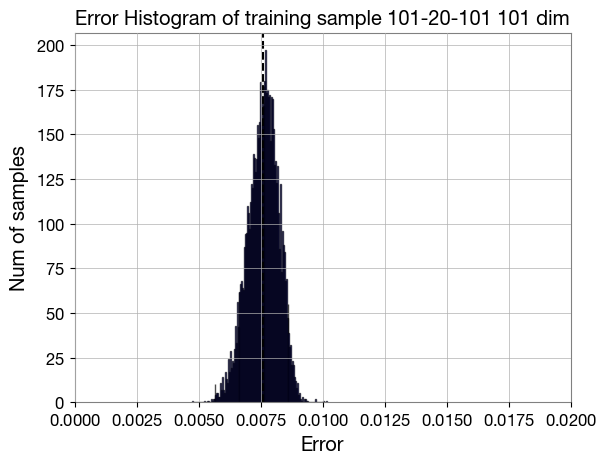

In [30]:
plt.hist(ReconstructedError_train, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of training sample 101-20-101 101 dim')
plt.xlim(0,0.02)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_train, color = 'black', linestyle = '--')
plt.show()

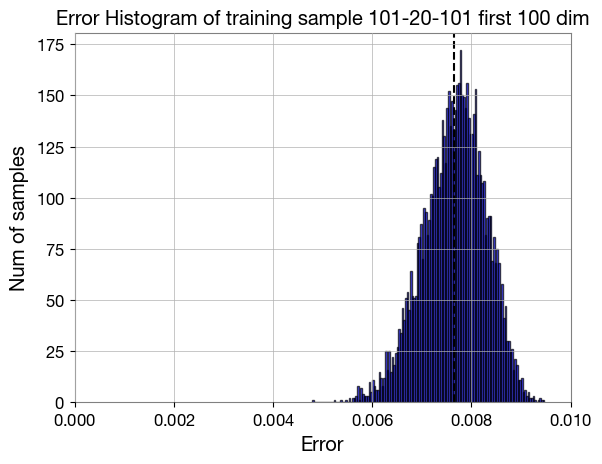

In [31]:
plt.hist(ReconstructedError_train_output, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of training sample 101-20-101 first 100 dim')
plt.xlim(0,0.01)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_train_output, color = 'black', linestyle = '--')
plt.show()

In [32]:
MSE_train_output

0.007648414438642514

In [449]:
_, decodedTestdata = autoencoder(testData)
decodedTestdata = decodedTestdata.double()
reconstructedData_test = decodedTestdata.detach().numpy()
ReconstructedError_test = torch.mean((testData - reconstructedData_test)**2,dim=1)
MSE_test = ReconstructedError_test.mean()

In [150]:
X_test_output = X_test[:, :100]
reconstructedData_test_output = reconstructedData_test[:, :100]

In [450]:
ReconstructedError_test_output_100d = np.mean((testData.numpy()[:, :100] - reconstructedData_test[:, :100])**2, axis = 1)
MSE_test_output_100d = ReconstructedError_test_output_100d.mean()

In [152]:
ReconstructedError_test_output_1d = (testData.numpy()[:, -1] - reconstructedData_test[:, -1])**2
MSE_test_output_1d = ReconstructedError_train_output_1d.mean()

In [73]:
MSE_test_output

0.0006501258602861813

In [22]:
MSE_test_output

1.1928150932025322e-06

Text(0, 0.5, 'Strain')

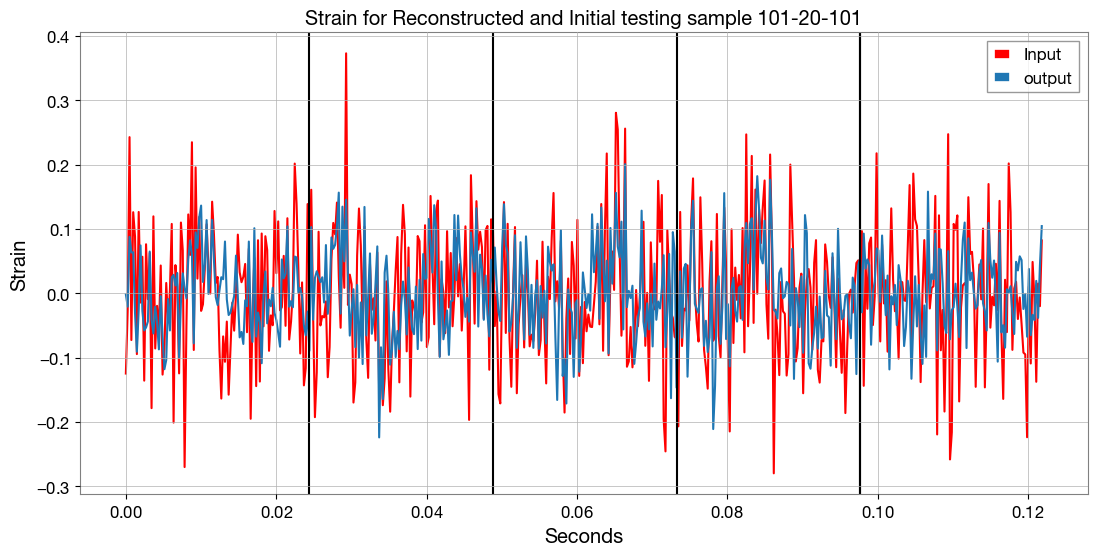

In [32]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,500/4096,1/4096)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_test_output

plt.figure(figsize=(13,6))
plt.plot(x, X_test_output.flatten()[0:500], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:500], label = 'output')
plt.axvline(x = 100/4096, color = 'black')
plt.axvline(x = 200/4096, color = 'black')
plt.axvline(x = 300/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.legend()
plt.title('Strain for Reconstructed and Initial testing sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

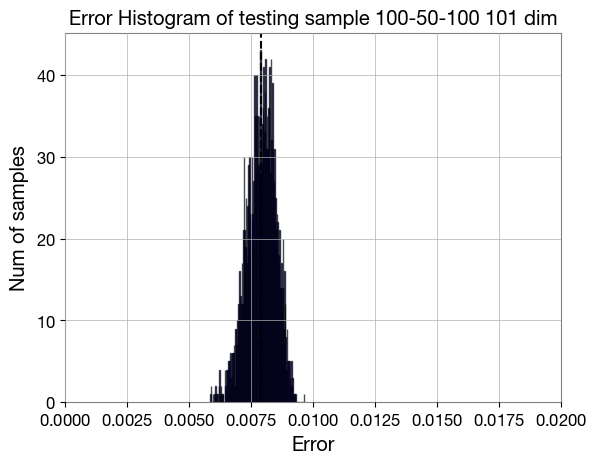

In [63]:
plt.hist(ReconstructedError_test, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of testing sample 100-50-100 101 dim')
plt.xlim(0,0.02)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_test, color = 'black', linestyle = '--')
plt.show()

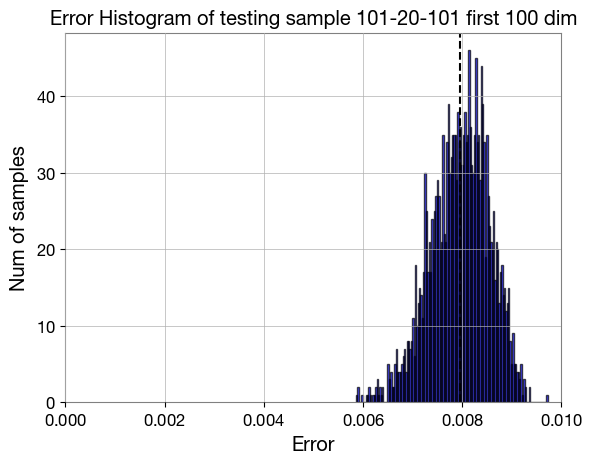

In [64]:
plt.hist(ReconstructedError_test_output, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of testing sample 101-20-101 first 100 dim')
plt.xlim(0,0.01)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_test_output, color = 'black', linestyle = '--')
plt.show()

In [35]:
MSE_test_output

0.008575124618823064

In [36]:
data_injected.shape

(199, 100)

In [132]:
data_injected_normalized = np.hstack((data_injected_normalized, np.ones((199, 1))))

In [451]:
data_injected_tensored = torch.FloatTensor(data_injected_normalized)
_, decodedTestdata = autoencoder(data_injected_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_injected = decodedTestdata.detach().numpy()
ReconstructedError_injected = torch.mean((data_injected_tensored - reconstructedData_injected)**2,dim=1)
MSE_injected = ReconstructedError_injected.mean()

In [452]:
ReconstructedError_injected_output_100d = np.mean((data_injected_tensored.numpy()[:, :100] - reconstructedData_injected[:, :100])**2, axis = 1)
MSE_injected_output_100d = ReconstructedError_injected_output_100d.mean()

In [40]:
ReconstructedError_injected_output = (data_injected_tensored.numpy()[:, :100] - reconstructedData_injected[:, :100])**2
MSE_injected_output = ReconstructedError_injected_output.mean()

In [155]:
ReconstructedError_injected_output_1d = (data_injected_tensored.numpy()[:, -1] - reconstructedData_injected[:, -1])**2
MSE_injected_output_1d = ReconstructedError_injected_output_1d.mean()

In [78]:
MSE_injected_output

0.028974691264861414

In [25]:
MSE_injected_output

0.0008165249368716545

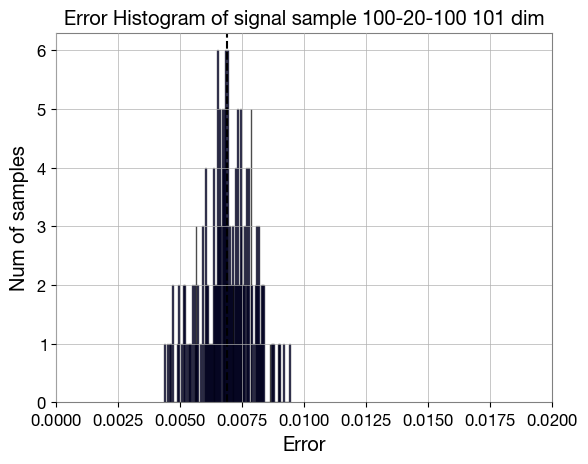

In [35]:
plt.hist(ReconstructedError_injected, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of signal sample 100-20-100 101 dim')
plt.xlim(0,0.02)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_injected, color = 'black', linestyle = '--')
plt.show()

Text(0, 0.5, 'Strain')

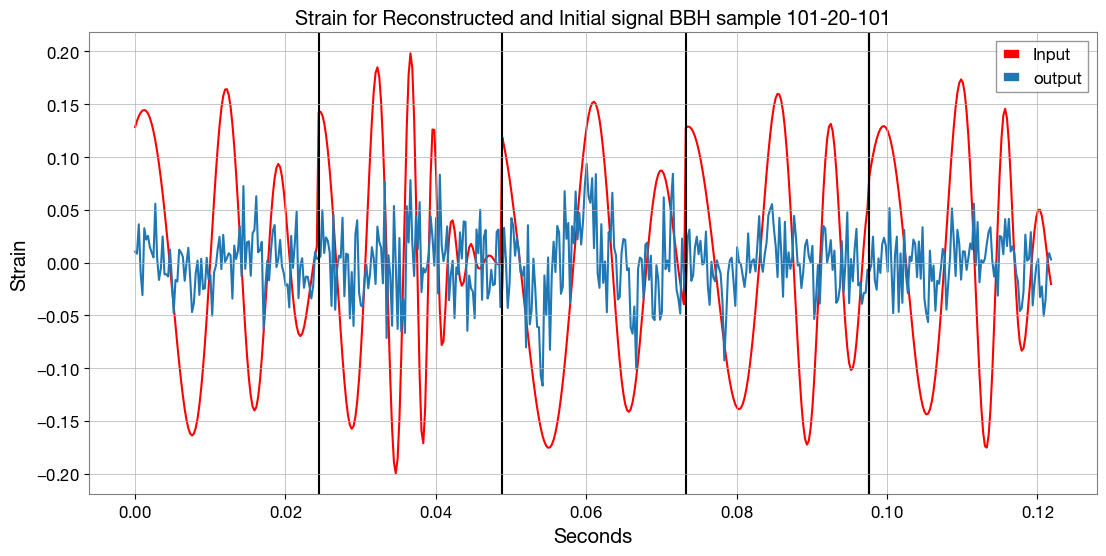

In [89]:
reconstructedData_injected_output = reconstructedData_injected[:, :100]
data_injected_normalized_output = data_injected_normalized[:, :100]
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,500/4096,1/4096)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_injected_output

plt.figure(figsize=(13,6))
plt.plot(x, data_injected_normalized_output.flatten()[0:500], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:500], label = 'output')
plt.axvline(x = 100/4096, color = 'black')
plt.axvline(x = 200/4096, color = 'black')
plt.axvline(x = 300/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.legend()
plt.title('Strain for Reconstructed and Initial signal BBH sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

Text(0, 0.5, 'Strain')

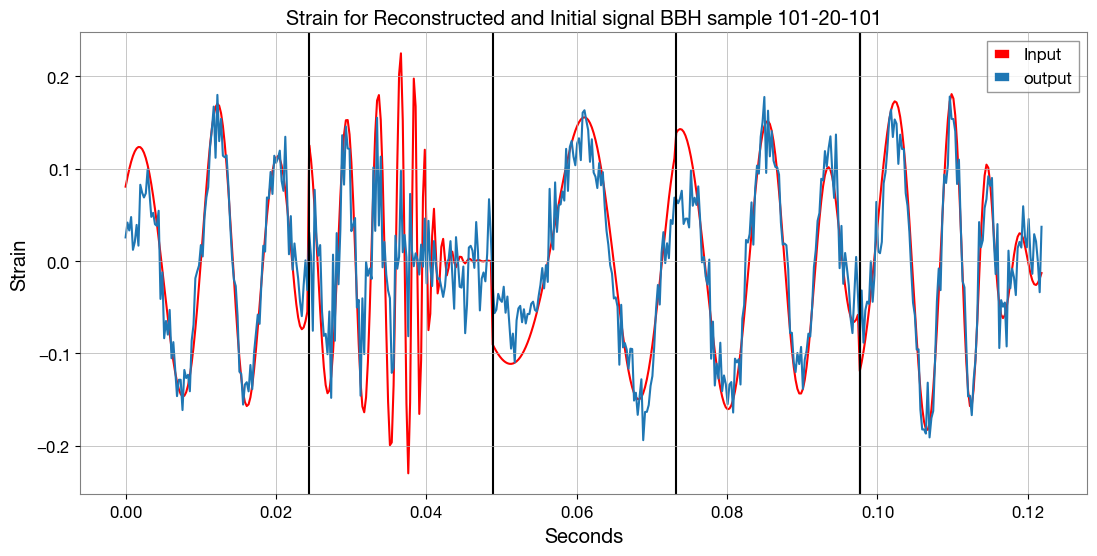

In [84]:
reconstructedData_injected_output = reconstructedData_injected[:, :100]
data_injected_normalized_output = data_injected_normalized[:, :100]
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,500/4096,1/4096)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_injected_output

plt.figure(figsize=(13,6))
plt.plot(x, data_injected_normalized_output.flatten()[0:500], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:500], label = 'output')
plt.axvline(x = 100/4096, color = 'black')
plt.axvline(x = 200/4096, color = 'black')
plt.axvline(x = 300/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.legend()
plt.title('Strain for Reconstructed and Initial signal BBH sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

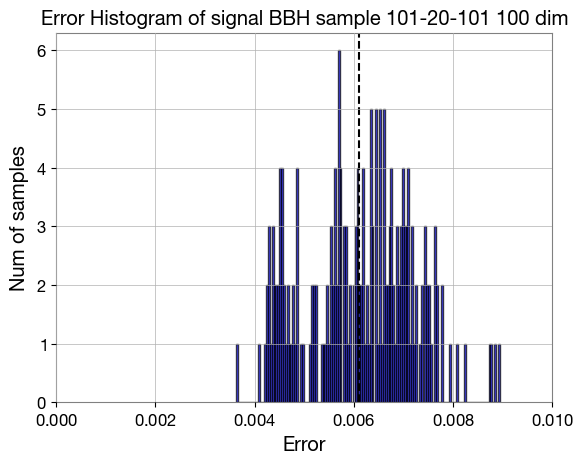

In [135]:
plt.hist(ReconstructedError_injected_output, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of signal BBH sample 101-20-101 100 dim')
plt.xlim(0,0.01)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_injected_output, color = 'black', linestyle = '--')
plt.show()

In [42]:
MSE_injected_output

0.007094492407737541

In [147]:
torch.save(autoencoder, '/Volumes/Research/GWNMMAD_data/Model/101-20-101_nonuniform_glitches_50%_trained/model.pt')

In [52]:
autoencoder = torch.load('/Volumes/Research/GWNMMAD_data/Model/101-20-101_nonuniform_norm_factor_100/model.pt')

In [45]:
data_injected = np.delete(np.load("../Data_cached/4000Hz25msnoise+datasampleBBH.npy"), 47, axis = 0)
data_injected = data_injected / np.linalg.norm(data_injected)
data_injected_normalized, junk1, junk2 = bunch_normalization(data_injected.copy())

AttributeError: 'list' object has no attribute 'reshape'

In [355]:
data_injected_normalized = np.hstack((data_injected_normalized, np.array(X_train_recover_coef[200:399]).reshape(len(data_injected_normalized), 1)))

In [53]:
data_injected_tensored = torch.FloatTensor(data_injected_normalized)
_, decodedTestdata = autoencoder(data_injected_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_injected = decodedTestdata.detach().numpy()
ReconstructedError_injected = torch.mean((data_injected_tensored - reconstructedData_injected)**2,dim=1)
MSE_injected = ReconstructedError_injected.mean()

In [59]:
ReconstructedError_injected_output = np.mean((data_injected_tensored.numpy()[:, :100] - reconstructedData_injected[:, :100])**2, axis = 1)
MSE_injected_output = ReconstructedError_injected_output.mean()

In [54]:
ReconstructedError_injected_output = (data_injected_tensored.numpy()[:, -1] - reconstructedData_injected[:, -1])**2
MSE_injected_output = ReconstructedError_injected_output.mean()

In [118]:
max(ReconstructedError_injected_output)

0.040670616990169606

In [119]:
MSE_injected_output

0.0008165249368716545

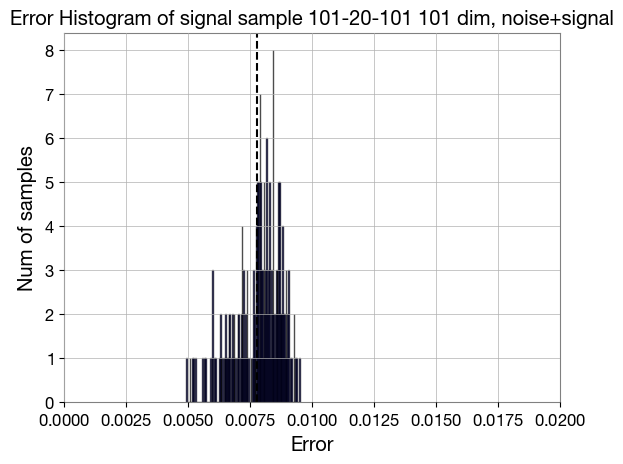

In [49]:
plt.hist(ReconstructedError_injected, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of signal sample 101-20-101 101 dim, noise+signal')
plt.xlim(0,0.02)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_injected, color = 'black', linestyle = '--')
plt.show()

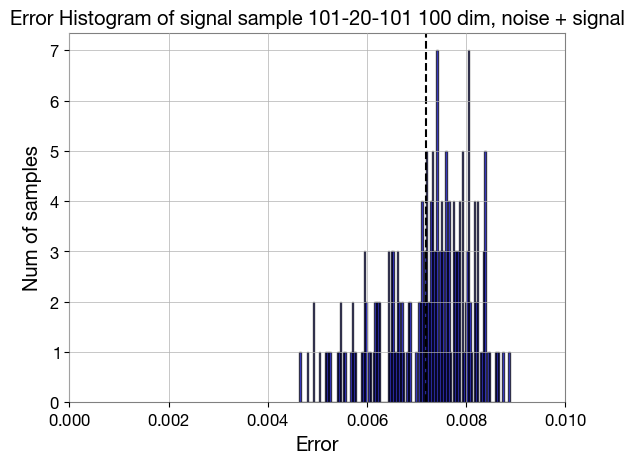

In [50]:
plt.hist(ReconstructedError_injected_output, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of signal sample 101-20-101 100 dim, noise + signal')
plt.xlim(0,0.01)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_injected_output, color = 'black', linestyle = '--')
plt.show()

In [62]:
data_sinegaussian = np.load('../Data_cached/4000Hz25mssampleSG7000.npy')
data_sinegaussian.shape

(7000, 100)

Text(0, 0.5, 'Strain')

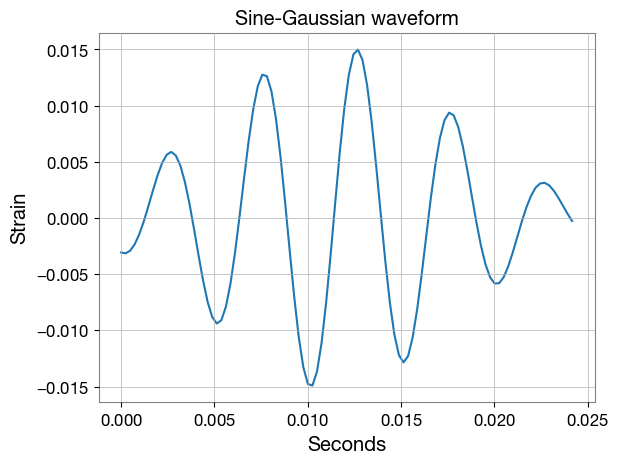

In [90]:
plt.plot(np.arange(0,100/4096, 1/4096), data_sinegaussian[14])
plt.title('Sine-Gaussian waveform')
plt.xlabel('Seconds')
plt.ylabel('Strain')

In [65]:
max(np.linalg.norm(data_sinegaussian, axis = 1))

0.9999999999999999

In [63]:
data_sinegaussian = data_sinegaussian / max(np.linalg.norm(data_sinegaussian, axis = 1))

In [64]:
np.linalg.norm(data_sinegaussian, axis = 1).mean()

0.4724192164490416

In [66]:
data_sinegaussian_normalized, junk3, junk4 = bunch_normalization(data_sinegaussian.copy())

In [67]:
data_sinegaussian_normalized = np.hstack((data_sinegaussian_normalized, np.array(junk4).reshape(len(data_sinegaussian_normalized),1)))

In [80]:
data_sinegaussian_normalized[:,-1]

array([0.49457535, 0.45900811, 0.5124364 , 0.40675264,
       0.04153278, 0.16201001, 0.16038457, 0.43482433,
       0.09259898, 0.40979325, 0.60052165, 0.51069954,
       0.41056685, 0.57157129, 0.4425903 , 0.50474416,
       0.50120401, 0.55721046, 0.6789139 , 0.75835134,
       0.06031665, 0.4508098 , 0.06476409, 0.49940189,
       0.01512473, 0.04593246, 0.75377972, 0.45161745,
       0.00238384, 0.91264473, 0.27188577, 0.07647197,
       0.45394301, 0.80291078, 0.57427162, 0.46739979,
       0.35699911, 0.68630239, 0.49759934, 0.13056747,
       0.47002272, 0.42164291, 0.45366507, 0.00397871,
       0.11805608, 0.22520925, 0.66079062, 0.56233651,
       0.65938782, 0.86623363, 0.26312363, 0.55099454,
       0.97980066, 0.41580928, 0.46668334, 0.75794052,
       0.42631569, 0.        , 0.95982234, 0.74631719,
       0.77607509, 0.64172489, 0.58087711, 0.42387551,
       0.71867189, 0.51625773, 0.73731016, 0.59324252,
       0.63867671, 0.48242688, 0.04718918, 0.45742711,
       0.8

In [453]:
data_sinegaussian_tensored = torch.FloatTensor(data_sinegaussian_normalized)
_, decodedTestdata = autoencoder(data_sinegaussian_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_sinegaussian = decodedTestdata.detach().numpy()
ReconstructedError_sinegaussian = torch.mean((data_sinegaussian_tensored - reconstructedData_sinegaussian)**2,dim=1)
MSE_sinegaussian = ReconstructedError_sinegaussian.mean()

In [454]:
ReconstructedError_sinegaussian_output_100d = np.mean((data_sinegaussian_tensored.numpy()[:, :100] - reconstructedData_sinegaussian[:, :100])**2, axis = 1)
MSE_sinegaussian_output_100d = ReconstructedError_sinegaussian_output_100d.mean()

In [158]:
ReconstructedError_sinegaussian_output_1d = (data_sinegaussian_tensored.numpy()[:, -1] - reconstructedData_sinegaussian[:, -1])**2
MSE_sinegaussian_output_1d = ReconstructedError_sinegaussian_output_1d.mean()

In [222]:
MSE_sinegaussian_output

0.00190188018920955

In [33]:
MSE_sinegaussian_output

0.002982299292766605

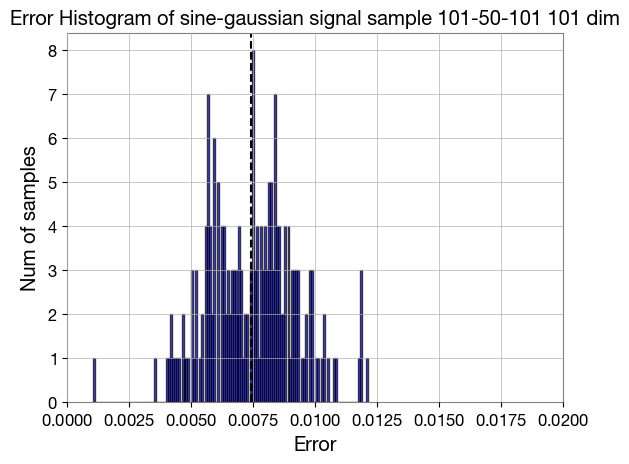

In [46]:
plt.hist(ReconstructedError_sinegaussian, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of sine-gaussian signal sample 101-50-101 101 dim')
plt.xlim(0,0.02)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_sinegaussian, color = 'black', linestyle = '--')
plt.show()

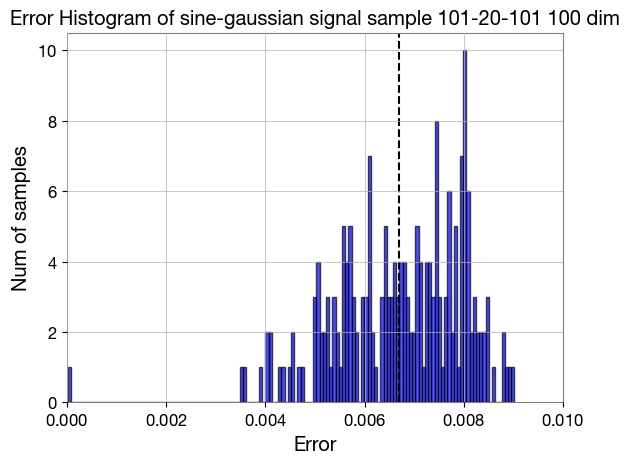

In [47]:
plt.hist(ReconstructedError_sinegaussian_output, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of sine-gaussian signal sample 101-20-101 100 dim')
plt.xlim(0,0.01)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_sinegaussian_output, color = 'black', linestyle = '--')
plt.show()

In [48]:
MSE_sinegaussian_output

0.0066982354932616575

In [88]:
reconstructedData_sinegaussian_output = reconstructedData_sinegaussian[:, :100]
data_sinegaussian_normalized_output = data_sinegaussian_normalized[:, :100]
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,500/4096,1/4096)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_sinegaussian_output

plt.figure(figsize=(13,6))
plt.plot(x, data_sinegaussian_normalized_output.flatten()[0:500], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:500], label = 'output')
plt.axvline(x = 100/4096, color = 'black')
plt.axvline(x = 200/4096, color = 'black')
plt.axvline(x = 300/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.legend()
plt.title('Strain for Reconstructed and Initial sine-gaussian sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

NameError: name 'reconstructedData_sinegaussian' is not defined

In [70]:
data_glitches= np.load('../Data_cached/4000Hz25mssampleglitch7000.npy')
data_glitches.shape

(7000, 100)

In [249]:
np.linalg.norm(data_glitches, axis = 1).mean()

0.03711428638867341

Text(0, 0.5, 'Strain')

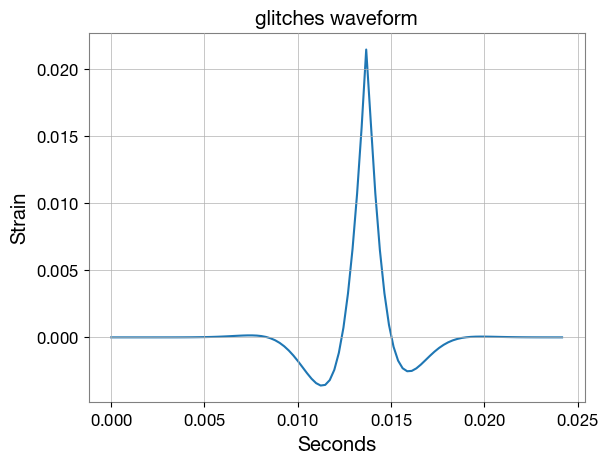

In [93]:
plt.plot(np.arange(0,100/4096, 1/4096), data_glitches[1])
plt.title('glitches waveform')
plt.xlabel('Seconds')
plt.ylabel('Strain')

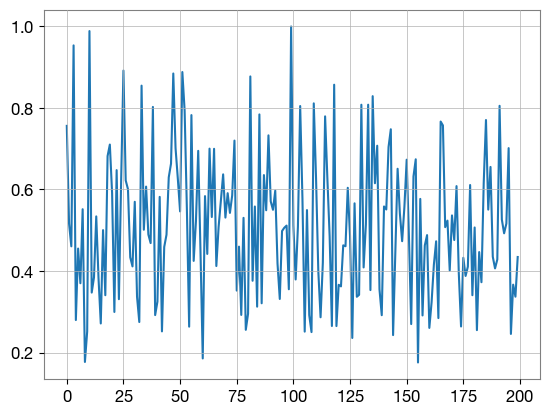

In [276]:
plt.plot(data_glitches_normalized[:,-1])

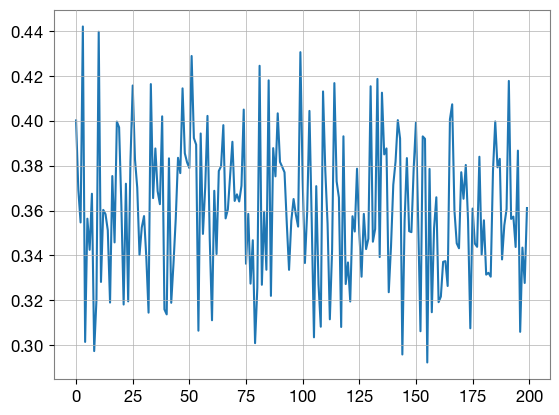

In [283]:
plt.plot(reconstructedData_glitches[:,-1])

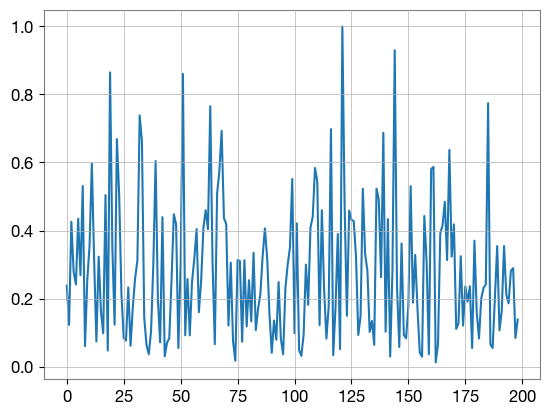

In [277]:
plt.plot(data_injected_normalized[:,-1])

(array([ 6.,  9., 13., 12., 13.,  7.,  7.,  7.,  7.,  4.,  4.,
        10.,  9.,  4.,  7., 14.,  3.,  6.,  1.,  5.,  8.,  8.,
         4.,  2.,  3.,  3.,  3.,  1.,  3.,  3.,  0.,  1.,  1.,
         1.,  3.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,  1.,  1.,
         0.,  0.,  1.,  0.,  0.,  1.]),
 array([0.01188622, 0.03164849, 0.05141077, 0.07117304,
        0.09093532, 0.11069759, 0.13045987, 0.15022215,
        0.16998442, 0.1897467 , 0.20950897, 0.22927125,
        0.24903352, 0.2687958 , 0.28855807, 0.30832035,
        0.32808263, 0.3478449 , 0.36760718, 0.38736945,
        0.40713173, 0.426894  , 0.44665628, 0.46641856,
        0.48618083, 0.50594311, 0.52570538, 0.54546766,
        0.56522993, 0.58499221, 0.60475449, 0.62451676,
        0.64427904, 0.66404131, 0.68380359, 0.70356586,
        0.72332814, 0.74309042, 0.76285269, 0.78261497,
        0.80237724, 0.82213952, 0.84190179, 0.86166407,
        0.88142635, 0.90118862, 0.9209509 , 0.94071317,
        0.96047545, 0.98023772, 1.  

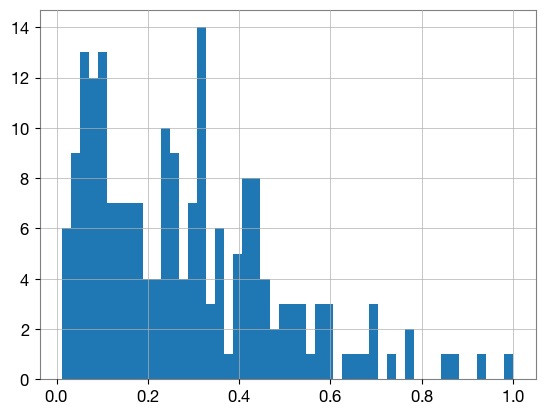

In [318]:
plt.hist(data_injected_normalized[:, -1], bins = 50)

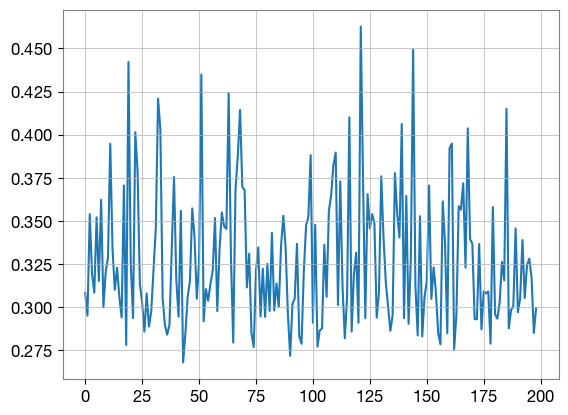

In [284]:
plt.plot(reconstructedData_injected[:,-1])

(array([3.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 4.000e+00,
        1.600e+01, 4.300e+01, 7.600e+01, 1.510e+02, 2.860e+02,
        4.860e+02, 6.800e+02, 8.600e+02, 9.410e+02, 1.004e+03,
        7.890e+02, 6.300e+02, 4.240e+02, 2.870e+02, 1.540e+02,
        7.800e+01, 4.100e+01, 1.600e+01, 4.000e+00, 1.000e+00]),
 array([0.00951257, 0.01773941, 0.02596625, 0.0341931 ,
        0.04241994, 0.05064679, 0.05887363, 0.06710048,
        0.07532732, 0.08355416, 0.09178101, 0.10000785,
        0.1082347 , 0.11646154, 0.12468839, 0.13291523,
        0.14114207, 0.14936892, 0.15759576, 0.16582261,
        0.17404945, 0.1822763 , 0.19050314, 0.19872998,
        0.20695683, 0.21518367, 

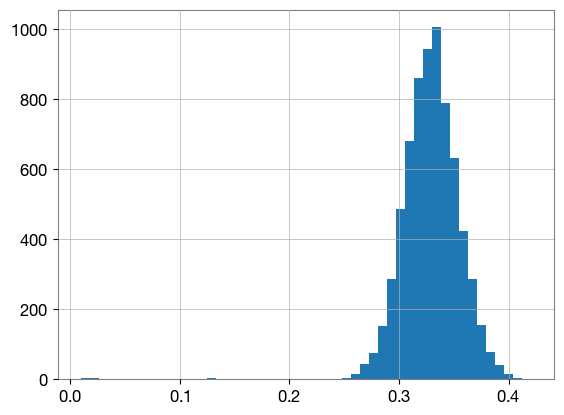

In [316]:
plt.hist(X_train[:,-1], bins = 50)

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,
         2.,  0.,  2.,  4.,  4.,  3.,  7.,  5.,  5.,  8.,  8.,
         9.,  5.,  8.,  6.,  8.,  5., 11.,  7.,  8., 11., 10.,
         7.,  4.,  8.,  8.,  5.,  3.,  7.,  5.,  1.,  0.,  4.,
         3.,  1.,  0.,  0.,  0.,  2.]),
 array([0.25757942, 0.26011092, 0.26264242, 0.26517392,
        0.26770541, 0.27023691, 0.27276841, 0.27529991,
        0.27783141, 0.28036291, 0.28289441, 0.2854259 ,
        0.2879574 , 0.2904889 , 0.2930204 , 0.2955519 ,
        0.2980834 , 0.3006149 , 0.30314639, 0.30567789,
        0.30820939, 0.31074089, 0.31327239, 0.31580389,
        0.31833539, 0.32086688, 0.32339838, 0.32592988,
        0.32846138, 0.33099288, 0.33352438, 0.33605588,
        0.33858737, 0.34111887, 0.34365037, 0.34618187,
        0.34871337, 0.35124487, 0.35377637, 0.35630786,
        0.35883936, 0.36137086, 0.36390236, 0.36643386,
        0.36896536, 0.37149686, 0.37402835, 0.37655985,
        0.37909135, 0.38162285, 0.38

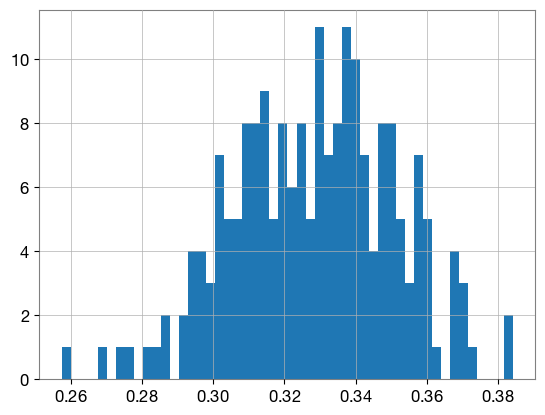

In [347]:
plt.hist(X_train[200:400][:,-1], bins = 50)

(array([ 5.,  3.,  3.,  5.,  1.,  2.,  2.,  0.,  2.,  2.,  0.,
         1.,  0.,  3.,  3.,  2.,  3.,  5.,  2.,  5., 14., 11.,
        13., 10.,  9.,  8.,  6.,  5.,  8.,  9.,  2.,  8.,  4.,
         5.,  3.,  3.,  5.,  5.,  2.,  0.,  3.,  3.,  3.,  2.,
         3.,  1.,  1.,  2.,  1.,  2.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16,
        0.18, 0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34,
        0.36, 0.38, 0.4 , 0.42, 0.44, 0.46, 0.48, 0.5 , 0.52,
        0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66, 0.68, 0.7 ,
        0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88,
        0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

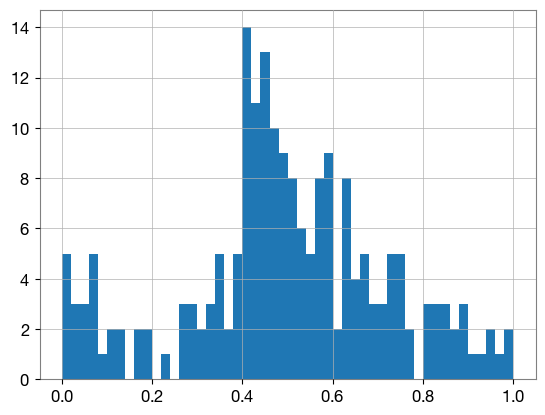

In [319]:
plt.hist(data_sinegaussian_normalized[:, -1], bins = 50)

(array([ 3.,  0.,  0.,  1.,  8.,  7.,  5.,  6.,  3.,  6.,  8.,
         5.,  5.,  4.,  7.,  6.,  5.,  7.,  7.,  6., 10.,  8.,
        10.,  6.,  6.,  5.,  5.,  9.,  2.,  2.,  3.,  5.,  3.,
         2.,  1.,  3.,  4.,  1.,  6.,  1.,  0.,  2.,  1.,  3.,
         0.,  0.,  0.,  1.,  0.,  2.]),
 array([-0.12446152, -0.10797229, -0.09148306, -0.07499383,
        -0.0585046 , -0.04201537, -0.02552614, -0.00903691,
         0.00745232,  0.02394155,  0.04043078,  0.05692001,
         0.07340924,  0.08989848,  0.10638771,  0.12287694,
         0.13936617,  0.1558554 ,  0.17234463,  0.18883386,
         0.20532309,  0.22181232,  0.23830155,  0.25479078,
         0.27128001,  0.28776924,  0.30425847,  0.3207477 ,
         0.33723693,  0.35372616,  0.37021539,  0.38670462,
         0.40319385,  0.41968308,  0.43617231,  0.45266154,
         0.46915077,  0.48564   ,  0.50212924,  0.51861847,
         0.5351077 ,  0.55159693,  0.56808616,  0.58457539,
         0.60106462,  0.61755385,  0.63404308,  

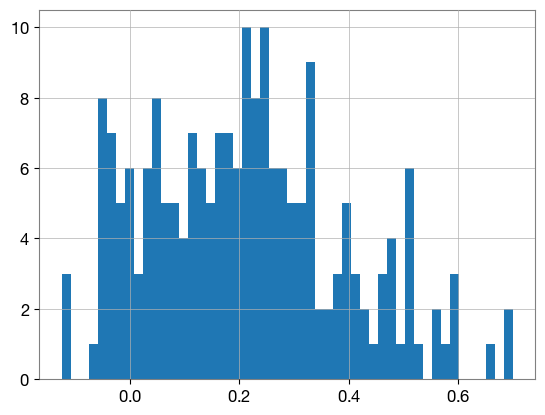

In [320]:
plt.hist(data_glitches_normalized[:, -1], bins = 50)

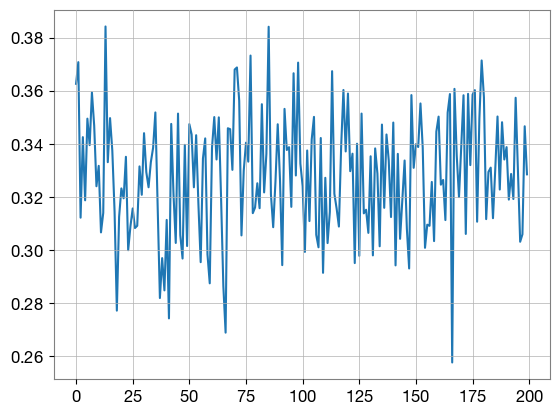

In [281]:
plt.plot(X_train[:,-1][200:400])

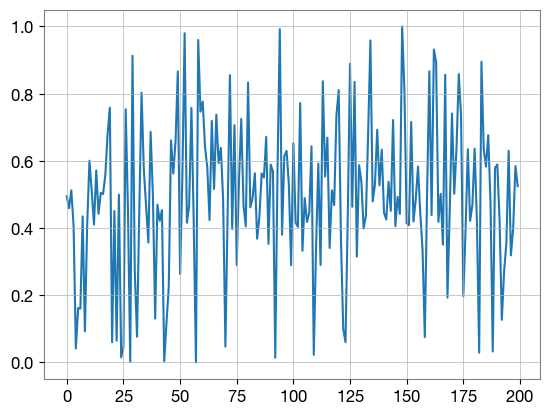

In [282]:
plt.plot(data_sinegaussian_normalized[:,-1])

In [455]:
# data_glitches = train_glitch_sample_modified_cut_test

In [72]:
max(np.linalg.norm(data_glitches, axis = 1))

1.0

In [71]:
data_glitches = data_glitches / max(np.linalg.norm(data_glitches, axis = 1))

In [457]:
data_glitches_normalized, junk5, junk6 = bunch_normalization(data_glitches.copy())

In [458]:
data_glitches_normalized = np.hstack((data_glitches_normalized, np.array(junk6).reshape(len(data_glitches_normalized),1)))

In [459]:
data_glitches_tensored = torch.FloatTensor(data_glitches_normalized)
_, decodedTestdata = autoencoder(data_glitches_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_glitches = decodedTestdata.detach().numpy()
ReconstructedError_glitches = torch.mean((data_glitches_tensored - reconstructedData_glitches)**2,dim=1)
MSE_glitches = ReconstructedError_glitches.mean()

In [460]:
ReconstructedError_glitches_output_100d = np.mean((data_glitches_tensored.numpy()[:, :100] - reconstructedData_glitches[:, :100])**2, axis = 1)
MSE_glitches_output_100d = ReconstructedError_glitches_output_100d.mean()

In [430]:
ReconstructedError_glitches_output_1d = (data_glitches_tensored.numpy()[:, -1] - reconstructedData_glitches[:, -1])**2
MSE_glitches_output_1d = ReconstructedError_glitches_output_1d.mean()

In [88]:
MSE_glitches_output

0.04440137327274874

In [41]:
MSE_glitches_output

0.0023010253566951144

-0.04779369618051016

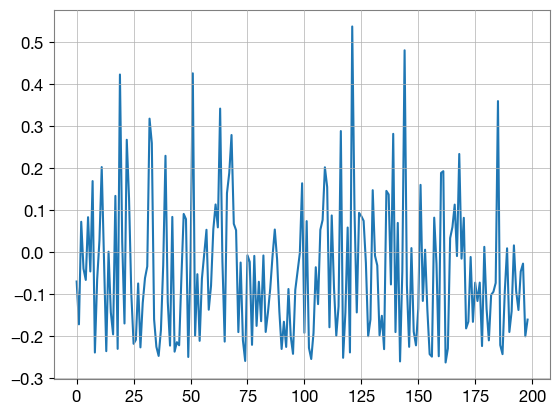

In [308]:
plt.plot((data_injected_tensored.numpy()[:, -1] - reconstructedData_injected[:, -1]))
(data_injected_tensored.numpy()[:, -1] - reconstructedData_injected[:, -1]).mean()

-0.004586538962321356

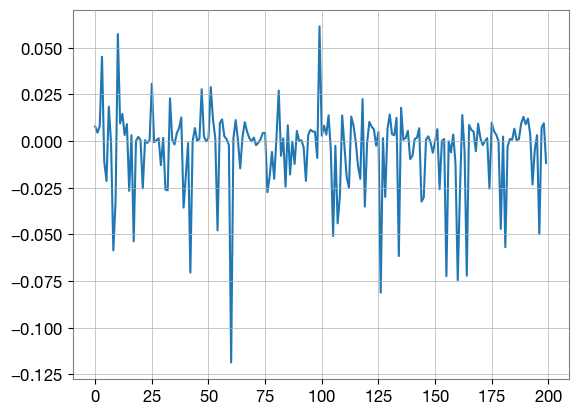

In [314]:
plt.plot((data_glitches_tensored.numpy()[:, -1] - reconstructedData_glitches[:, -1]))
(data_glitches_tensored.numpy()[:, -1] - reconstructedData_glitches[:, -1]).mean()

In [272]:
ReconstructedError_glitches_output.sum()

8.880274654549748

In [338]:
MSE_glitches_output

1.9880394134697e-06

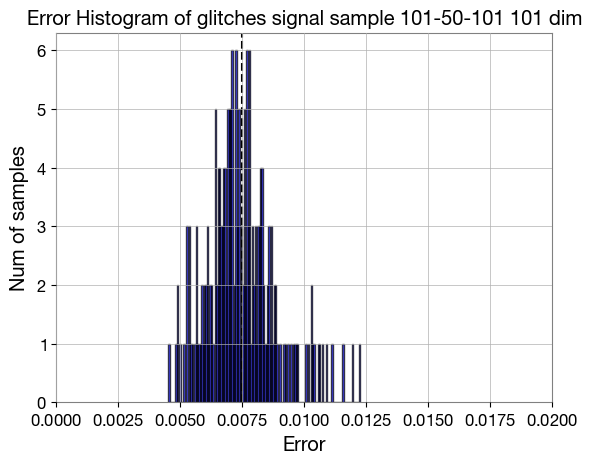

In [57]:
plt.hist(ReconstructedError_glitches, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of glitches signal sample 101-50-101 101 dim')
plt.xlim(0,0.02)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_glitches, color = 'black', linestyle = '--')
plt.show()

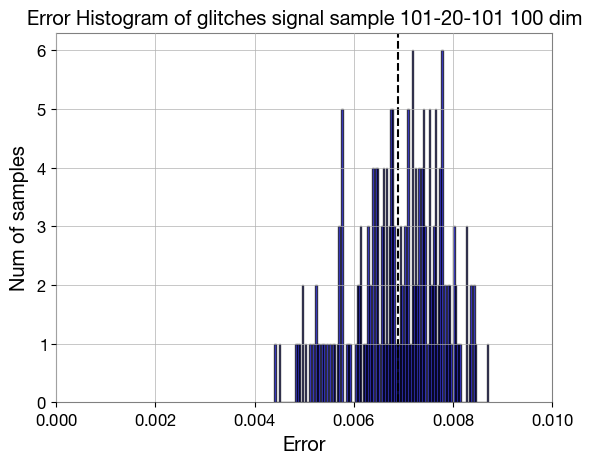

In [58]:
plt.hist(ReconstructedError_glitches_output, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of glitches signal sample 101-20-101 100 dim')
plt.xlim(0,0.01)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_glitches_output, color = 'black', linestyle = '--')
plt.show()

In [313]:
MSE_glitches_output

0.0005216723145263592

Text(0, 0.5, 'Strain')

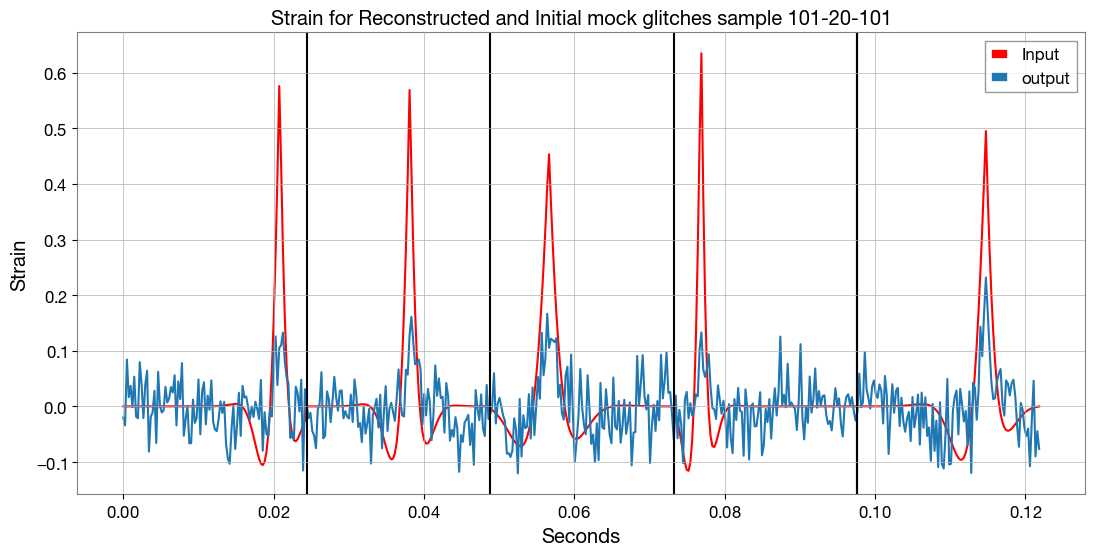

In [69]:
reconstructedData_glitches_output = reconstructedData_glitches[:, :100]
data_glitches_normalized_output = data_glitches_normalized[:, :100]
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,500/4096,1/4096)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_glitches_output

plt.figure(figsize=(13,6))
plt.plot(x, data_glitches_normalized_output.flatten()[0:500], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:500], label = 'output')
plt.axvline(x = 100/4096, color = 'black')
plt.axvline(x = 200/4096, color = 'black')
plt.axvline(x = 300/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.legend()
plt.title('Strain for Reconstructed and Initial mock glitches sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

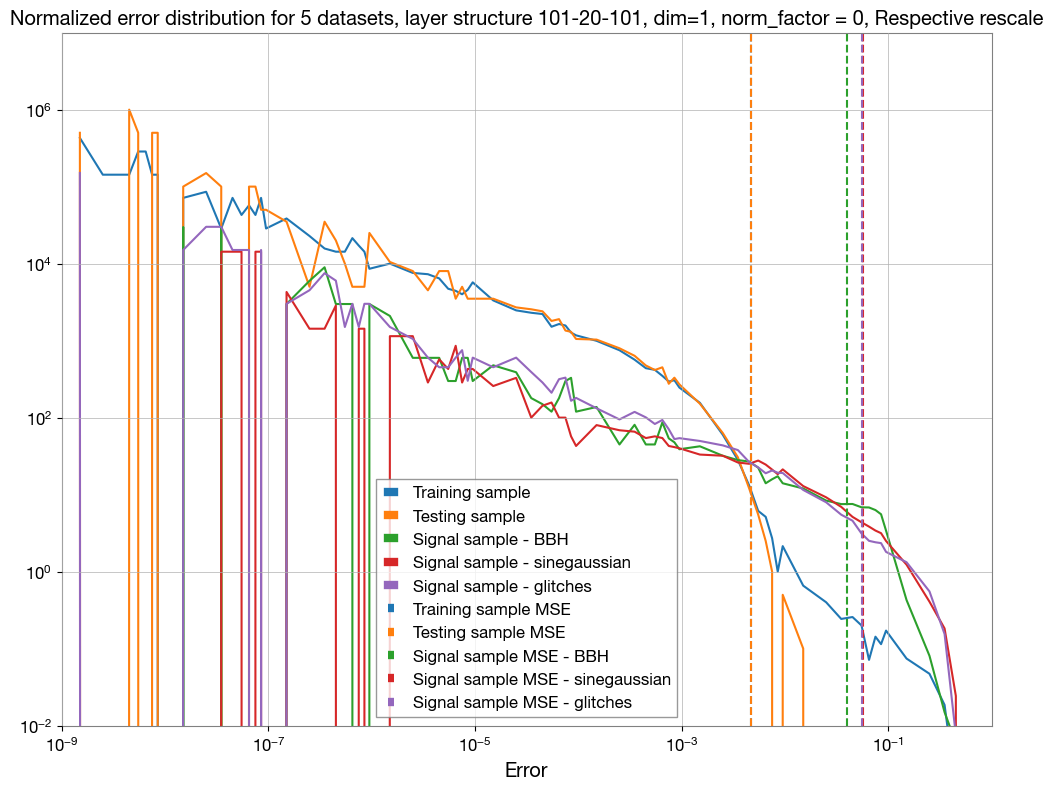

In [90]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bin_scheme = [1e-9, 2e-9, 3e-9, 4e-9, 5e-9, 6e-9, 7e-9, 8e-9, 9e-9, 1e-8, 2e-8, 3e-8, 4e-8, 5e-8, 6e-8, 7e-8, 8e-8, 9e-8, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7, 8e-7, 9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1, 8e-1, 9e-1]
def generate_custom_bins(start, end, interval):
    bin_edges = []
    edge = start
    bin_edges.append(start)
    while(edge < end):
        bin_edges.append(edge)
        edge = edge + interval
    return bin_edges

# bin_scheme = generate_custom_bins(1e-7, 1e-1, 1e-7)

counts_train, bin_position_train = np.histogram(ReconstructedError_train_output, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test_output, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected_output, bins = bin_scheme, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output, bins = bin_scheme, density = True)
counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - glitches')

plt.axvline(x = MSE_train_output, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test_output, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_injected_output, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
plt.axvline(x = MSE_sinegaussian_output, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
plt.axvline(x = MSE_glitches_output, color = colors[4], linestyle = '--', label = 'Signal sample MSE - glitches')

plt.xlim(1e-9, 1)
plt.ylim(1e-2, 1e7)
plt.xlabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.title('Normalized error distribution for 5 datasets, layer structure 101-20-101, dim=1, norm_factor = 0, Respective rescale')
plt.legend()
plt.show()

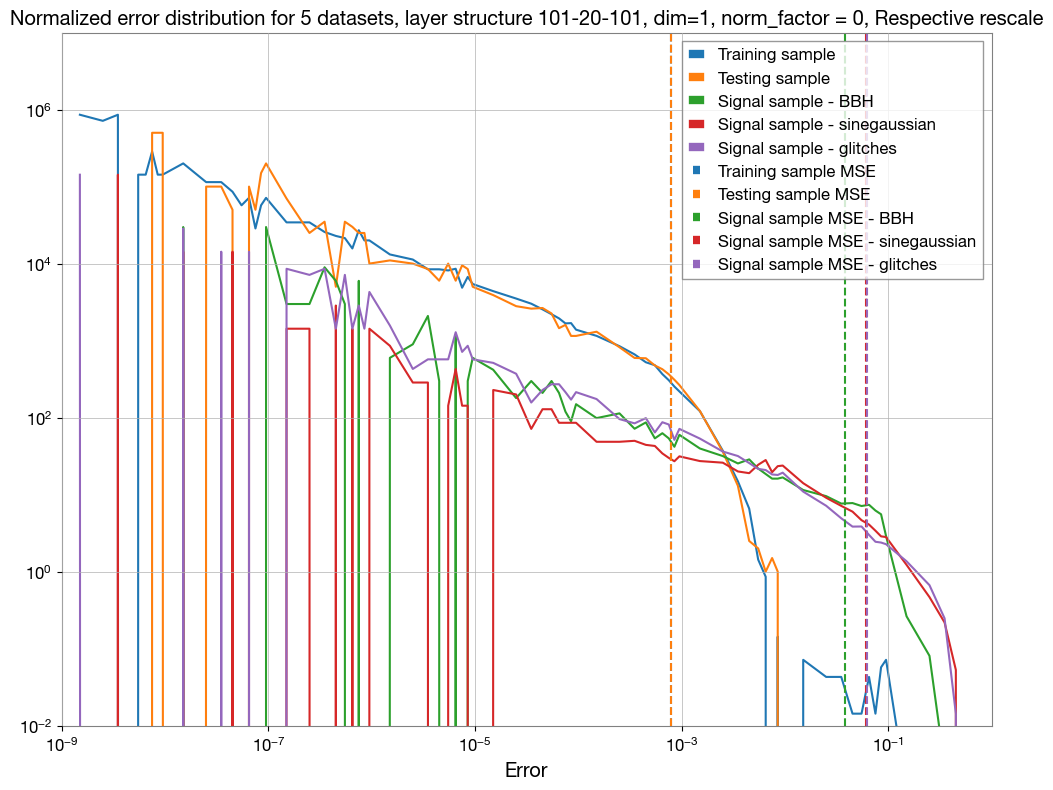

In [201]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bin_scheme = [1e-9, 2e-9, 3e-9, 4e-9, 5e-9, 6e-9, 7e-9, 8e-9, 9e-9, 1e-8, 2e-8, 3e-8, 4e-8, 5e-8, 6e-8, 7e-8, 8e-8, 9e-8, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7, 8e-7, 9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1, 8e-1, 9e-1]
def generate_custom_bins(start, end, interval):
    bin_edges = []
    edge = start
    bin_edges.append(start)
    while(edge < end):
        bin_edges.append(edge)
        edge = edge + interval
    return bin_edges

# bin_scheme = generate_custom_bins(1e-7, 1e-1, 1e-7)

counts_train, bin_position_train = np.histogram(ReconstructedError_train_output, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test_output, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected_output, bins = bin_scheme, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output, bins = bin_scheme, density = True)
counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - glitches')

plt.axvline(x = MSE_train_output, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test_output, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_injected_output, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
plt.axvline(x = MSE_sinegaussian_output, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
plt.axvline(x = MSE_glitches_output, color = colors[4], linestyle = '--', label = 'Signal sample MSE - glitches')

plt.xlim(1e-9, 1)
plt.ylim(1e-2, 1e7)
plt.xlabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.title('Normalized error distribution for 5 datasets, layer structure 101-20-101, dim=1, norm_factor = 0, Respective rescale')
plt.legend()
plt.show()

In [291]:
np.argwhere(ReconstructedError_train_output > 3e-5)

array([[19],
       [20]])

In [292]:
np.argwhere(ReconstructedError_test_output > 3e-5)

array([[ 927],
       [1314]])

In [303]:
max(ReconstructedError_test_output)

0.00013172138119443844

In [370]:
TPR_01_BBH = np.argwhere(ReconstructedError_injected_output > max(max(ReconstructedError_test_output), max(ReconstructedError_train_output))).shape[0]/len(ReconstructedError_injected_output)
TPR_01_BBH

0.030792227204783258

In [371]:
TPR_01_SG = np.argwhere(ReconstructedError_sinegaussian_output > max(max(ReconstructedError_test_output), max(ReconstructedError_train_output))).shape[0]/len(ReconstructedError_sinegaussian_output)
TPR_01_SG

0.18328571428571427

In [372]:
TPR_01_Glitch = np.argwhere(ReconstructedError_glitches_output > max(max(ReconstructedError_test_output), max(ReconstructedError_train_output))).shape[0]/len(ReconstructedError_glitches_output)
TPR_01_Glitch

0.218

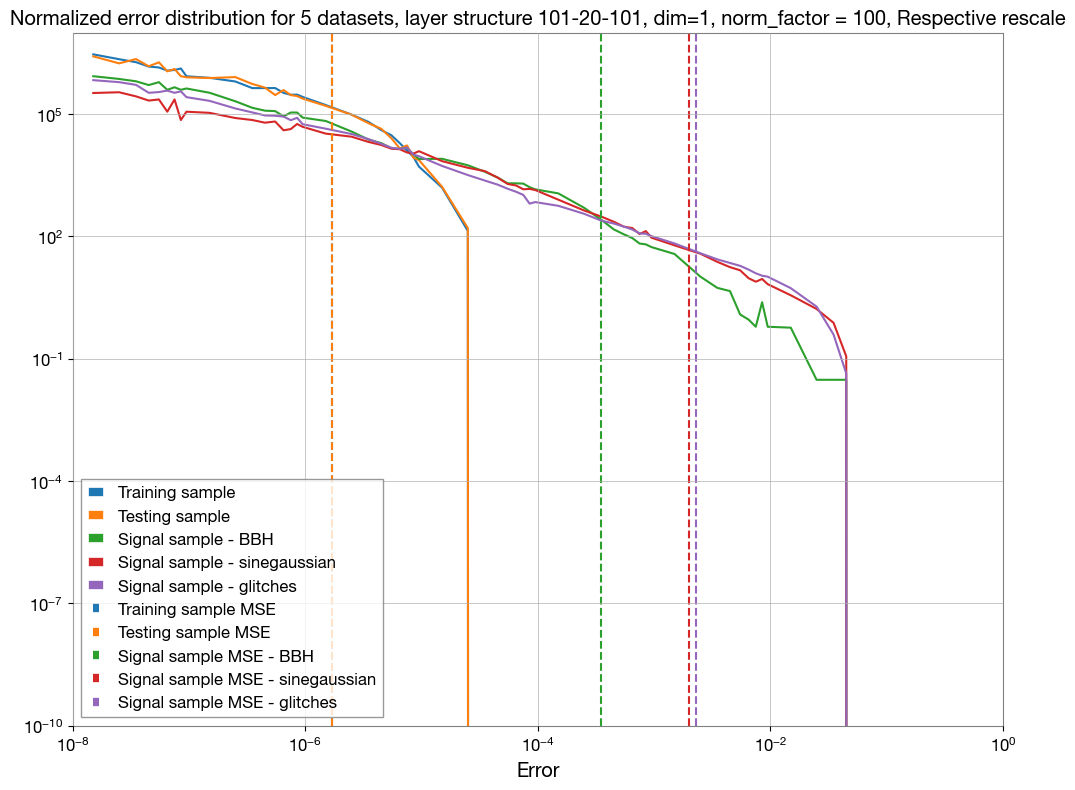

In [306]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bin_scheme = [1e-8, 2e-8, 3e-8, 4e-8, 5e-8, 6e-8, 7e-8, 8e-8, 9e-8, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7, 8e-7, 9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1]
def generate_custom_bins(start, end, interval):
    bin_edges = []
    edge = start
    bin_edges.append(start)
    while(edge < end):
        bin_edges.append(edge)
        edge = edge + interval
    return bin_edges

# bin_scheme = generate_custom_bins(1e-7, 1e-1, 1e-7)

counts_train, bin_position_train = np.histogram(ReconstructedError_train_output_1d, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test_output_1d, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected_output, bins = bin_scheme, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_1d, bins = bin_scheme, density = True)
counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_1d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - glitches')

plt.axvline(x = MSE_train_output_1d, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test_output_1d, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_injected_output, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
plt.axvline(x = MSE_sinegaussian_output_1d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
plt.axvline(x = MSE_glitches_output_1d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - glitches')

plt.xlim(0.00000001, 1)
plt.ylim(1e-10, 1e7)
plt.xlabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.title('Normalized error distribution for 5 datasets, layer structure 101-20-101, dim=1, norm_factor = 100, Respective rescale')
plt.legend()
plt.show()

In [321]:
TPR_100_BBH = np.argwhere(ReconstructedError_injected_output > max(ReconstructedError_test_output)).shape[0]/len(ReconstructedError_injected_output)
TPR_100_BBH

0.476831091180867

In [322]:
TPR_100_SG = np.argwhere(ReconstructedError_sinegaussian_output > max(ReconstructedError_test_output)).shape[0]/len(ReconstructedError_sinegaussian_output)
TPR_100_SG

0.6491428571428571

In [323]:
TPR_100_Glitch = np.argwhere(ReconstructedError_glitches_output > max(ReconstructedError_test_output)).shape[0]/len(ReconstructedError_glitches_output)
TPR_100_Glitch

0.5962857142857143

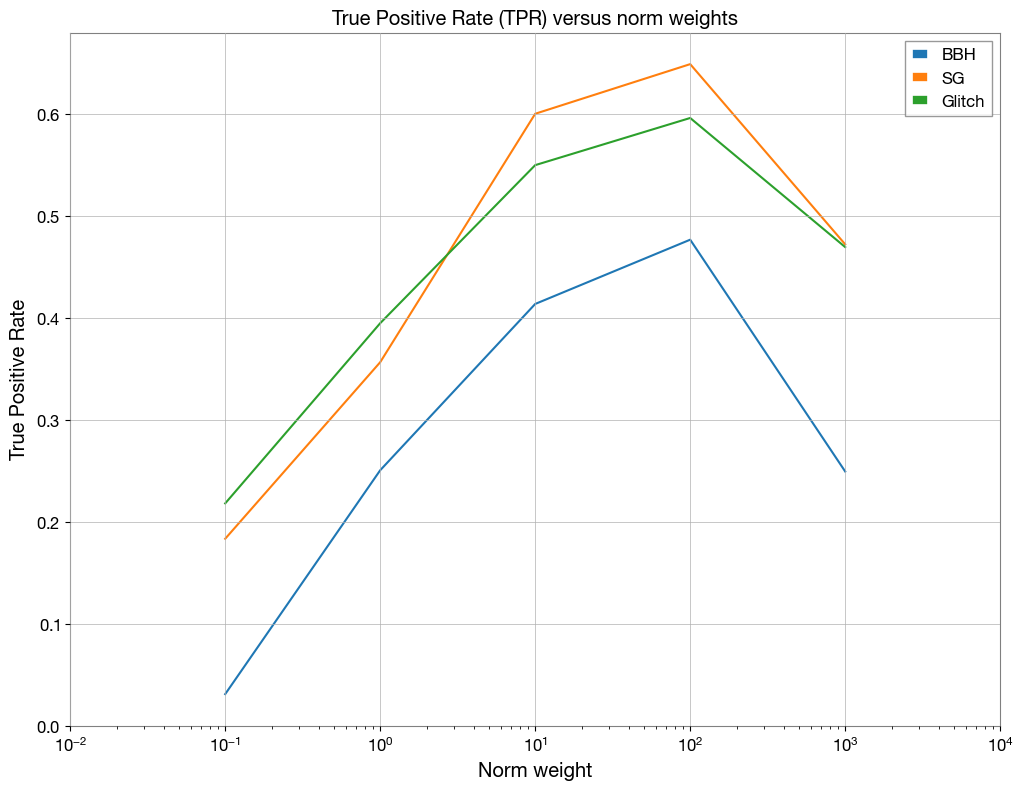

In [391]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

TPR_BBH = [TPR_01_BBH, TPR_1_BBH, TPR_10_BBH, TPR_100_BBH, TPR_1000_BBH]
TPR_SG = [TPR_01_SG, TPR_1_SG, TPR_10_SG, TPR_100_SG, TPR_1000_SG]
TPR_Glitch = [TPR_01_Glitch, TPR_1_Glitch, TPR_10_Glitch, TPR_100_Glitch, TPR_1000_Glitch]
Weights = [0.1, 1, 10, 100, 1000]

plt.figure(figsize=(12, 9))

plt.plot(Weights, TPR_BBH, label = 'BBH')
plt.plot(Weights, TPR_SG, label = 'SG')
plt.plot(Weights, TPR_Glitch, label = 'Glitch')

plt.xlim(1e-2, 1e4)
plt.xlabel('Norm weight')
plt.ylabel('True Positive Rate')
plt.xscale('log')
plt.title('True Positive Rate (TPR) versus norm weights')
plt.legend()
plt.show()

(array([4242.,  558.,  266.,  197.,  168.,  110.,   98.,   84.,
          65.,   87.,   63.,   55.,   50.,   44.,   44.,   30.,
          35.,   29.,   30.,   21.]),
 array([1.25774946e-11, 2.49945932e-04, 4.99891851e-04,
        7.49837771e-04, 9.99783690e-04, 1.24972961e-03,
        1.49967553e-03, 1.74962145e-03, 1.99956737e-03,
        2.24951329e-03, 2.49945921e-03, 2.74940513e-03,
        2.99935104e-03, 3.24929696e-03, 3.49924288e-03,
        3.74918880e-03, 3.99913472e-03, 4.24908064e-03,
        4.49902656e-03, 4.74897248e-03, 4.99891840e-03]),
 <BarContainer object of 20 artists>)

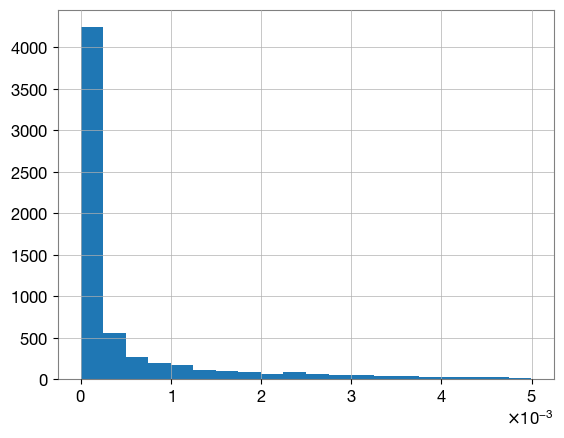

In [232]:
plt.hist(ReconstructedError_sinegaussian_output[ReconstructedError_sinegaussian_output < 0.005], bins = 20)

In [230]:
ReconstructedError_sinegaussian_output.mean()

0.00190188018920955

In [433]:
glitched_noise_number

657

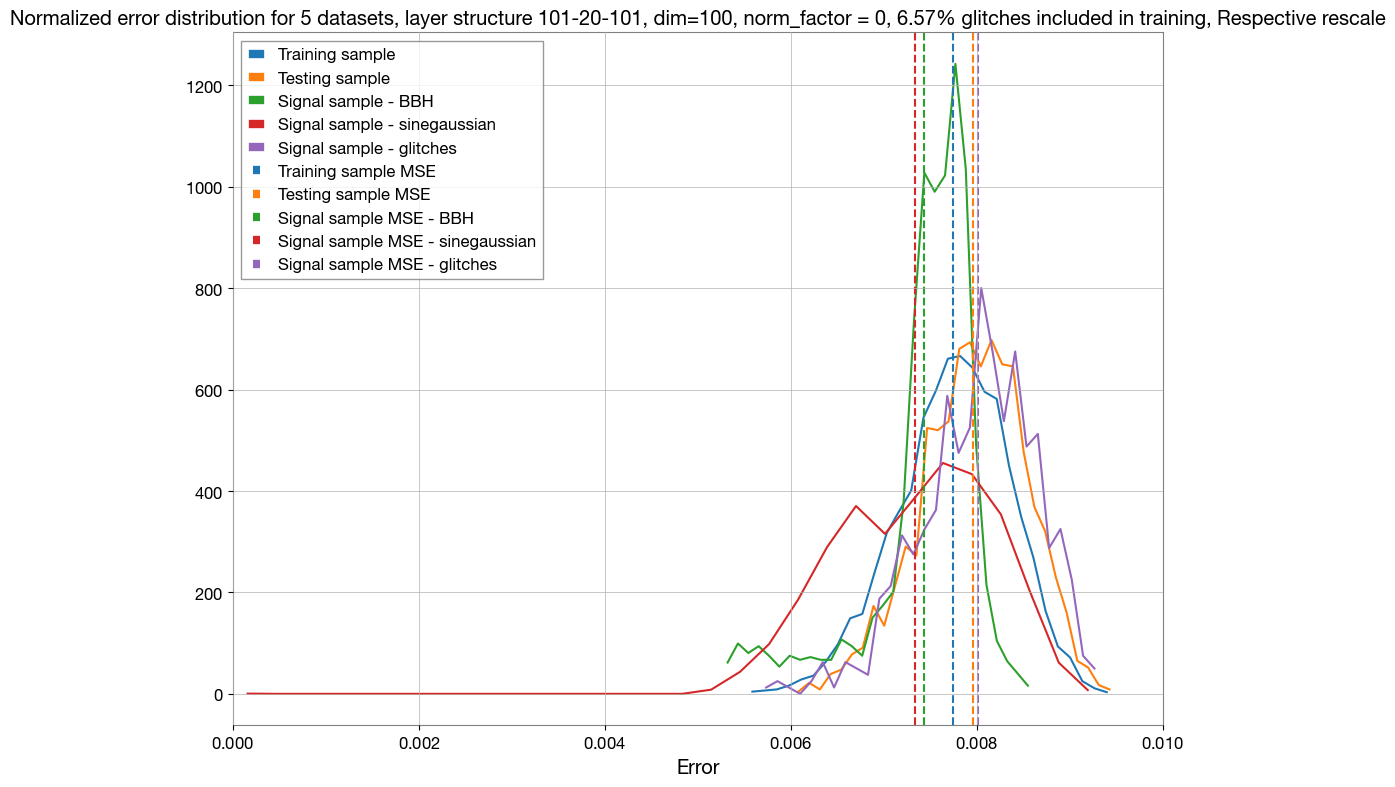

In [434]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

counts_train, bin_position_train = np.histogram(ReconstructedError_train_output_100d, bins = 30, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test_output_100d, bins = 30, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected_output_100d, bins = 30, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_100d, bins = 30, density = True)
counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = 30, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - glitches')

plt.axvline(x = MSE_train_output_100d, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test_output_100d, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_injected_output_100d, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
plt.axvline(x = MSE_sinegaussian_output_100d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - glitches')

plt.xlim(0, 0.01)
plt.xlabel('Error')
plt.title('Normalized error distribution for 5 datasets, layer structure 101-20-101, dim=100, norm_factor = 0, 6.57% glitches included in training, Respective rescale')
plt.legend()
plt.show()

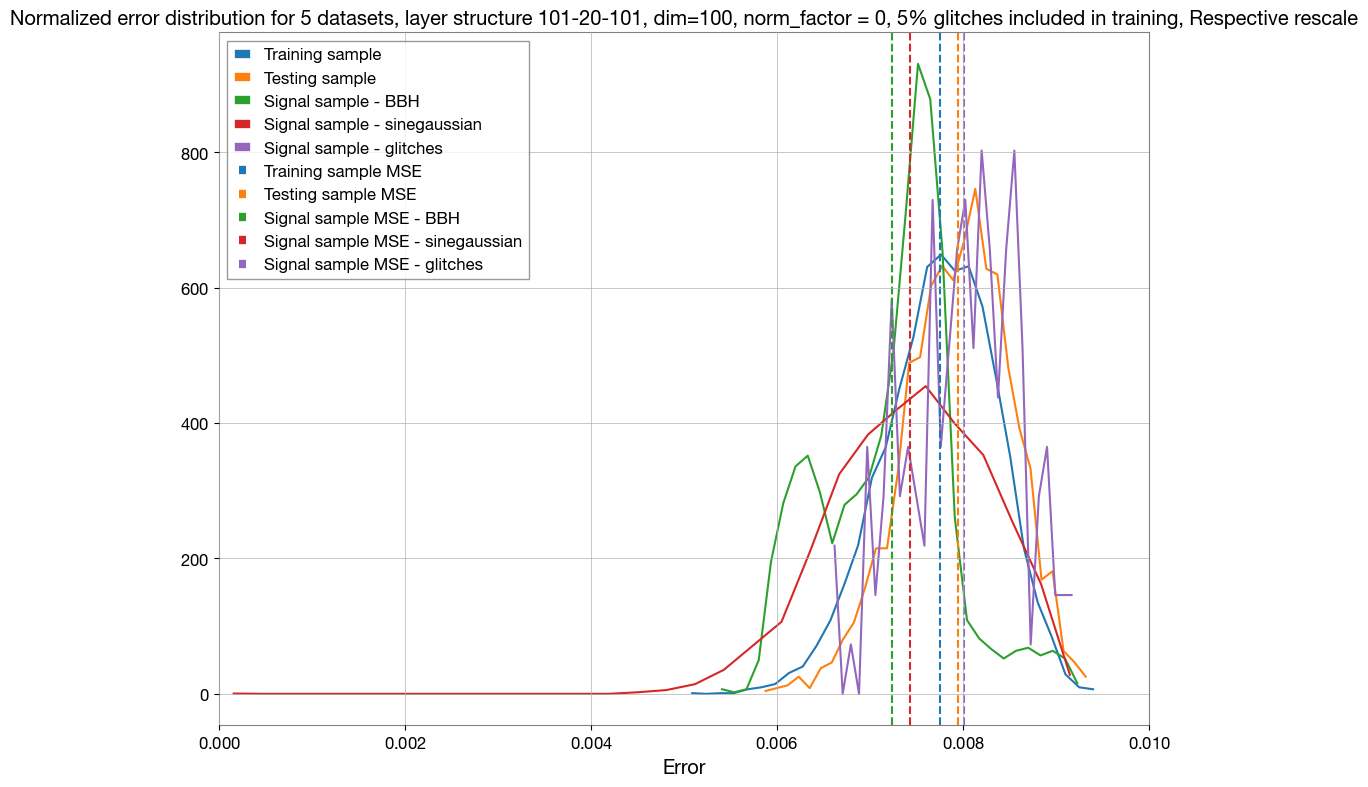

In [461]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

counts_train, bin_position_train = np.histogram(ReconstructedError_train_output_100d, bins = 30, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test_output_100d, bins = 30, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected_output_100d, bins = 30, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_100d, bins = 30, density = True)
counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = 30, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - glitches')

plt.axvline(x = MSE_train_output_100d, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test_output_100d, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_injected_output_100d, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
plt.axvline(x = MSE_sinegaussian_output_100d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - glitches')

plt.xlim(0, 0.01)
plt.xlabel('Error')
plt.title('Normalized error distribution for 5 datasets, layer structure 101-20-101, dim=100, norm_factor = 0, 5% glitches included in training, Respective rescale')
plt.legend()
plt.show()

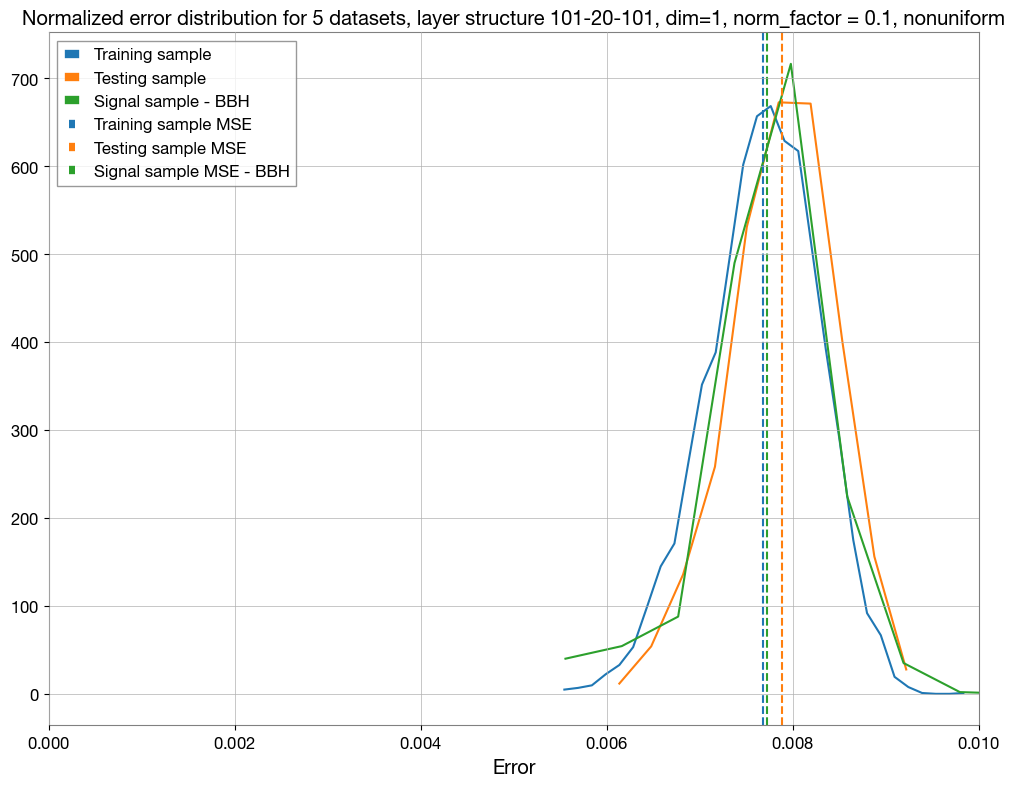

In [424]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = 30, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = 10, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected, bins = 10, density = True)
# counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output, bins = 10, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output, bins = 10, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - glitches')

plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_injected, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_sinegaussian_output, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output, color = colors[4], linestyle = '--', label = 'Signal sample MSE - glitches')

plt.xlim(0, 0.01)
plt.xlabel('Error')
plt.title('Normalized error distribution for 5 datasets, layer structure 101-20-101, dim=1, norm_factor = 0.1, nonuniform')
plt.legend()
plt.show()

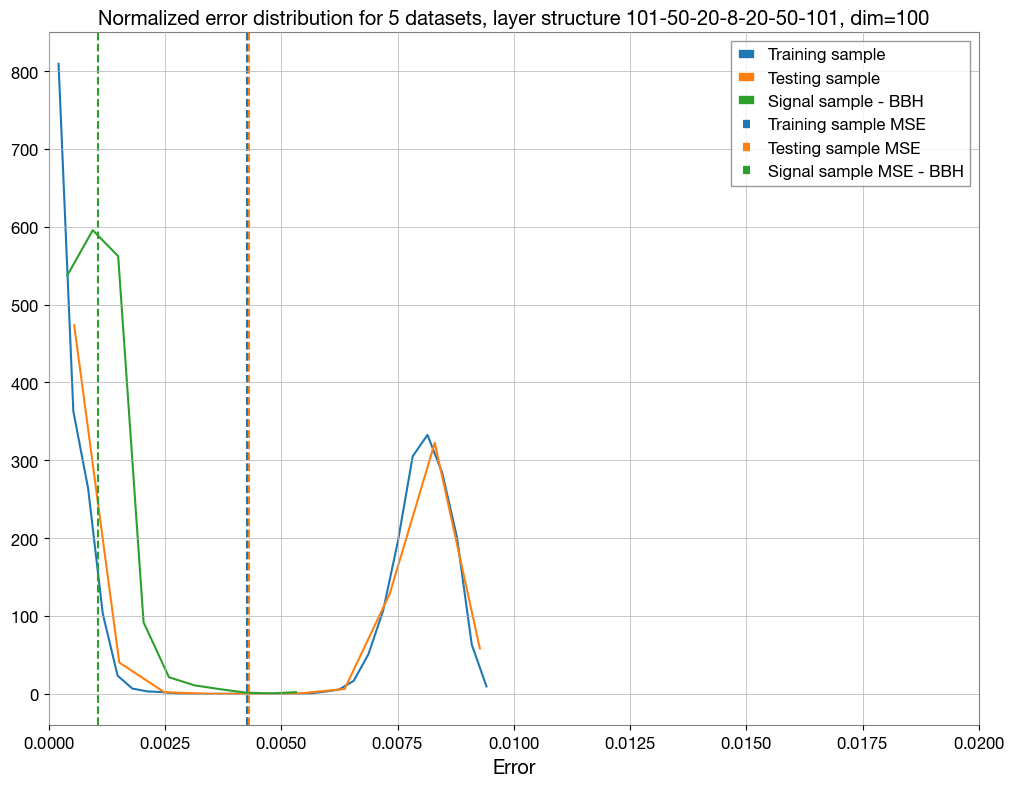

In [162]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

counts_train, bin_position_train = np.histogram(ReconstructedError_train_output, bins = 30, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test_output, bins = 10, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected_output, bins = 10, density = True)
# counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output, bins = 10, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output, bins = 10, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - glitches')

plt.axvline(x = MSE_train_output, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test_output, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_injected_output, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_sinegaussian_output, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output, color = colors[4], linestyle = '--', label = 'Signal sample MSE - glitches')

plt.xlim(0, 0.02)
plt.xlabel('Error')
plt.title('Normalized error distribution for 5 datasets, layer structure 101-50-20-8-20-50-101, dim=100')
plt.legend()
plt.show()

In [15]:
data_entire_event = np.load("../Data_cached/4096Hz25msentiresignalBBH.npy")

In [18]:
np.linalg.norm(data_entire_event, axis = 1)

array([0.21337418, 0.59027121, 0.53051549, 0.59035475,
       0.65949806, 0.77689434, 1.        , 0.69476813])

In [17]:
data_entire_event = data_entire_event / max(np.linalg.norm(data_entire_event, axis = 1))

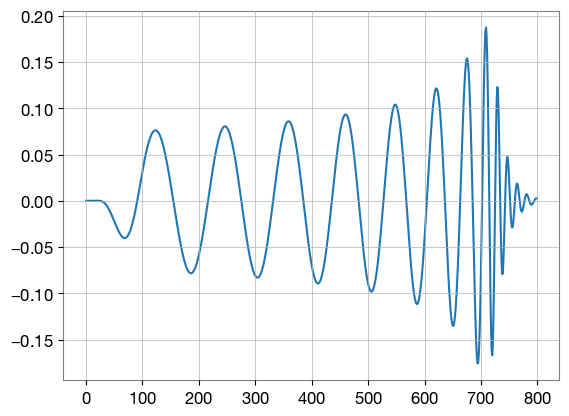

In [29]:
plt.plot(data_entire_event.flatten())

In [19]:
data_entire_event_normalized, _, junk7 = bunch_normalization(data_entire_event)

In [20]:
data_entire_event_normalized = np.hstack((data_entire_event_normalized, np.array(junk7).reshape(8,1)))

In [21]:
data_entire_event_tensored = torch.FloatTensor(data_entire_event_normalized)
_, decodedTestdata = autoencoder(data_entire_event_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_entire_event = decodedTestdata.detach().numpy()
ReconstructedError_entire_event = torch.mean((data_entire_event_tensored - reconstructedData_entire_event)**2,dim=1)
MSE_entire_event = ReconstructedError_entire_event.mean()

In [24]:
ReconstructedError_entire_event_output = (data_entire_event_tensored.numpy()[:, :100] - reconstructedData_entire_event[:, :100])**2
MSE_entire_event_output = ReconstructedError_entire_event_output.mean()

In [25]:
ReconstructedError_entire_event_output.shape

(8, 100)

In [28]:
MSE_entire_event_output

0.006532332981059562

Text(0, 0.5, 'MSE')

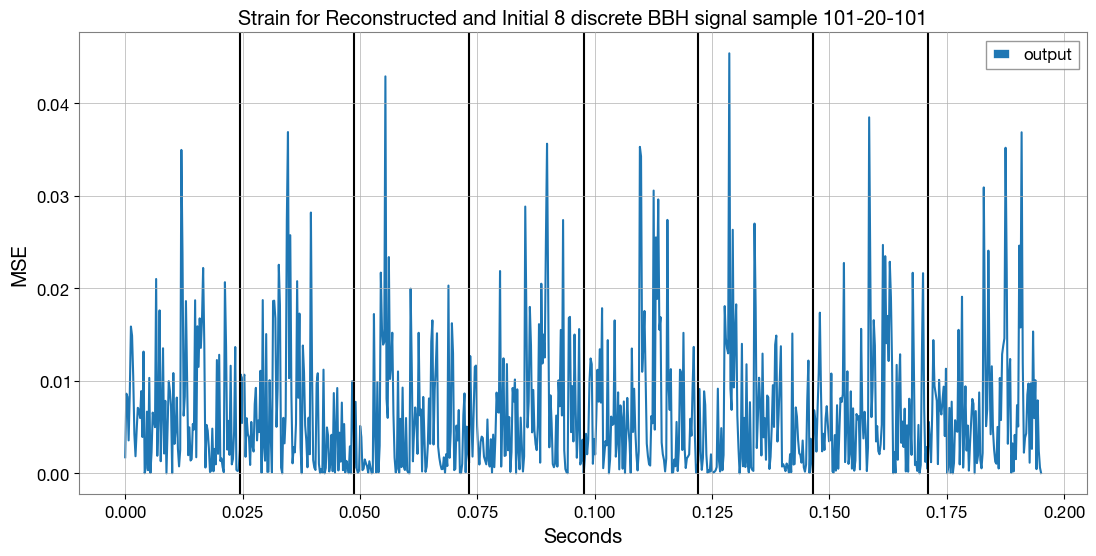

In [42]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,800/4096,1/4096)
# y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = ReconstructedError_injected_output

plt.figure(figsize=(13,6))
# plt.plot(x, data_glitches_normalized_output.flatten()[0:500], color = 'red', label = 'Input')
plt.plot(x, y[0:8].flatten(), label = 'output')
plt.axvline(x = 100/4096, color = 'black')
plt.axvline(x = 200/4096, color = 'black')
plt.axvline(x = 300/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.axvline(x = 500/4096, color = 'black')
plt.axvline(x = 600/4096, color = 'black')
plt.axvline(x = 700/4096, color = 'black')
# plt.axvline(x = 800/4096, color = 'black')
plt.legend()
plt.title('Strain for Reconstructed and Initial 8 discrete BBH signal sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

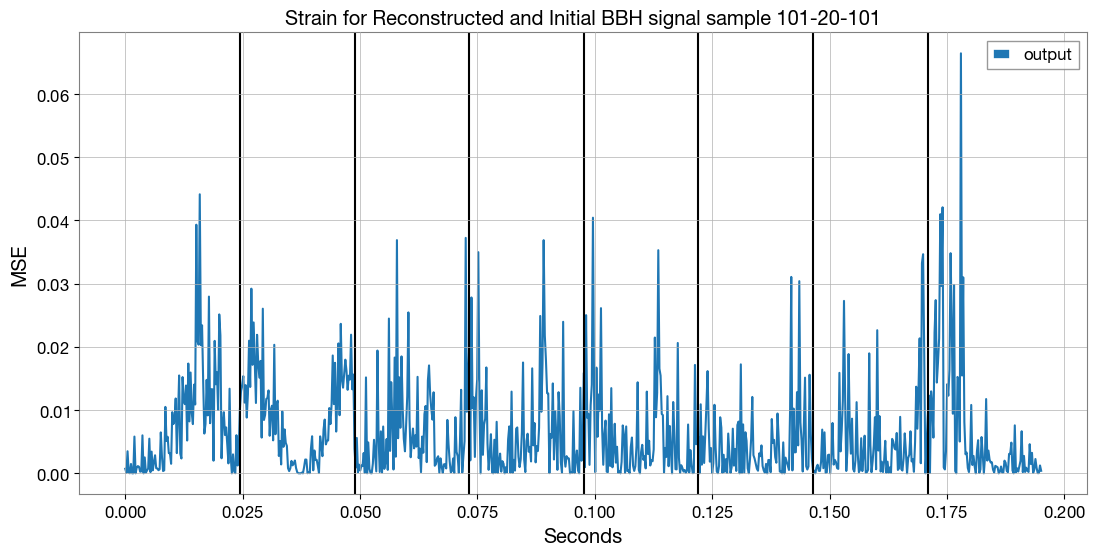

In [27]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,800/4096,1/4096)
# y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = ReconstructedError_entire_event_output

plt.figure(figsize=(13,6))
# plt.plot(x, data_glitches_normalized_output.flatten()[0:500], color = 'red', label = 'Input')
plt.plot(x, y.flatten(), label = 'output')
plt.axvline(x = 100/4096, color = 'black')
plt.axvline(x = 200/4096, color = 'black')
plt.axvline(x = 300/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.axvline(x = 500/4096, color = 'black')
plt.axvline(x = 600/4096, color = 'black')
plt.axvline(x = 700/4096, color = 'black')
# plt.axvline(x = 800/4096, color = 'black')
plt.legend()
plt.title('Strain for Reconstructed and Initial BBH signal sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('MSE')

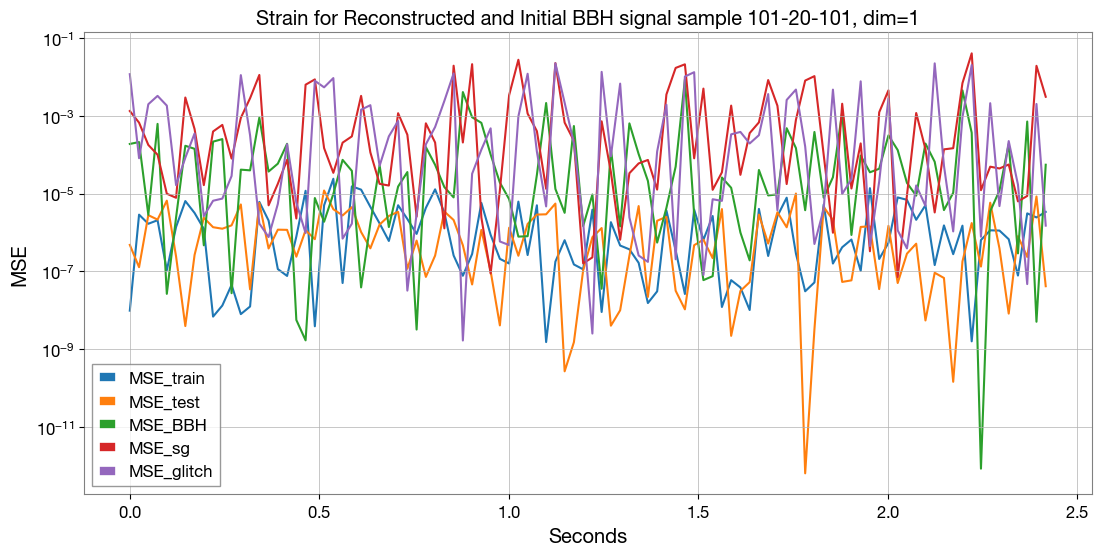

In [93]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,10000/4096,100/4096)
# y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = ReconstructedError_injected_output

plt.figure(figsize=(13,6))
# plt.plot(x, data_glitches_normalized_output.flatten()[0:500], color = 'red', label = 'Input')
plt.plot(x, ReconstructedError_train_output[0:100].flatten(), label = 'MSE_train')
plt.plot(x, ReconstructedError_test_output[0:100].flatten(), label = 'MSE_test')
plt.plot(x, y[0:100].flatten(), label = 'MSE_BBH')
plt.plot(x, ReconstructedError_sinegaussian_output[0:100].flatten(), label = 'MSE_sg')
plt.plot(x, ReconstructedError_glitches_output[0:100].flatten(), label = 'MSE_glitch')
# plt.axvline(x = 100/4096, color = 'black')
# plt.axvline(x = 200/4096, color = 'black')
# plt.axvline(x = 300/4096, color = 'black')
# plt.axvline(x = 400/4096, color = 'black')
# plt.axvline(x = 500/4096, color = 'black')
# plt.axvline(x = 600/4096, color = 'black')
# plt.axvline(x = 700/4096, color = 'black')
# plt.axvline(x = 800/4096, color = 'black')
plt.legend()
plt.title('Strain for Reconstructed and Initial BBH signal sample 101-20-101, dim=1')
plt.xlabel('Seconds')
plt.ylabel('MSE')
plt.yscale('log')

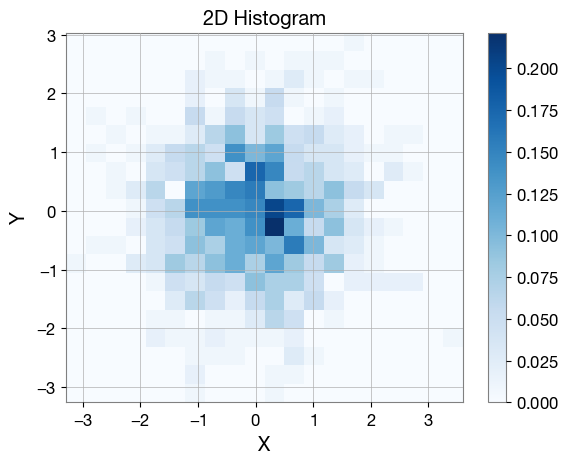

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# 生成随机二维数据
x = np.random.randn(1000)
y = np.random.randn(1000)

# 绘制二维直方图
plt.hist2d(x, y, bins=20, cmap='Blues', density='True')

# 添加颜色条
plt.colorbar()

# 添加标题和轴标签
plt.title('2D Histogram')
plt.xlabel('X')
plt.ylabel('Y')
# plt.yscale('log')

# 显示图形
plt.show()

In [167]:
ReconstructedError_train_output_1d.shape

(7000,)

/var/folders/2v/3ndz_6mx79z7p4z3mfgc3kvc0000gn/T/ipykernel_51181/1529860675.py:14: RuntimeWarning: divide by zero encountered in log
  hist = np.log(hist)


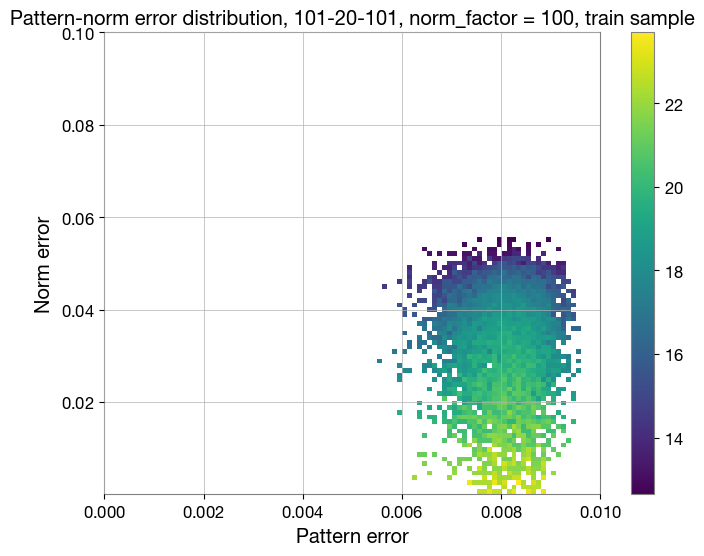

In [310]:
# 生成随机二维数据
# x = np.random.randn(1000)
# y = np.random.randn(1000)

# 指定直方图箱的数量
bins_x = np.arange(0, 0.01, 1e-4)
# bins_x = np.logspace(-3, -1, 50)
# bins_y = [1e-8, 2e-8, 3e-8, 4e-8, 5e-8, 6e-8, 7e-8, 8e-8, 9e-8, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7, 8e-7, 9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1]
bins_y = np.logspace(-9, -1, num = 100)


# 计算二维直方图的统计数据
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_train_output_100d,ReconstructedError_train_output_1d, bins=[bins_x, bins_y], density='True')
hist = np.log(hist)

# 可视化二维直方图
# aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 100, train sample')
plt.xlabel('Pattern error')
plt.ylabel('Norm error')
plt.xscale('linear')
plt.yscale('linear')
plt.xlim(0, 0.01)

# 显示图形
plt.show()

In [307]:
max(ReconstructedError_train_output_1d)

2.5717602775365833e-05

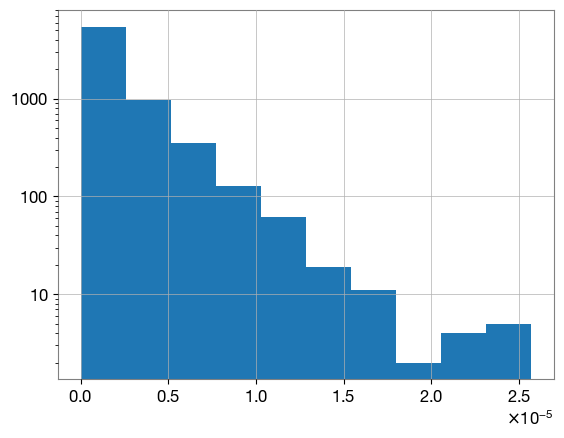

In [184]:
plt.hist(ReconstructedError_train_output_1d)
plt.yscale('log')

/var/folders/2v/3ndz_6mx79z7p4z3mfgc3kvc0000gn/T/ipykernel_51181/2639697159.py:13: RuntimeWarning: divide by zero encountered in log
  hist = np.log(hist)


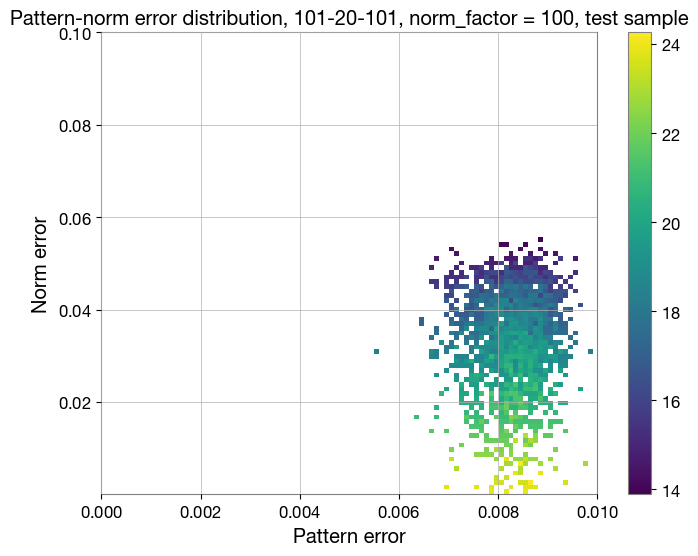

In [211]:
# 生成随机二维数据
# x = np.random.randn(1000)
# y = np.random.randn(1000)

# 指定直方图箱的数量
bins_x = np.arange(0, 0.01, 1e-4)
# bins_x = np.logspace(-3, -1, 50)
# bins_y = [1e-8, 2e-8, 3e-8, 4e-8, 5e-8, 6e-8, 7e-8, 8e-8, 9e-8, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7, 8e-7, 9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1]
bins_y = np.logspace(-9, -1, 100)

# 计算二维直方图的统计数据
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_test_output_100d,ReconstructedError_test_output_1d, bins=[bins_x, bins_y], density='True')
hist = np.log(hist)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 100, test sample')
plt.xlabel('Pattern error')
plt.ylabel('Norm error')
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, 0.01)

# 显示图形
plt.show()

/var/folders/2v/3ndz_6mx79z7p4z3mfgc3kvc0000gn/T/ipykernel_51181/1628346586.py:13: RuntimeWarning: divide by zero encountered in log
  hist = np.log(hist)


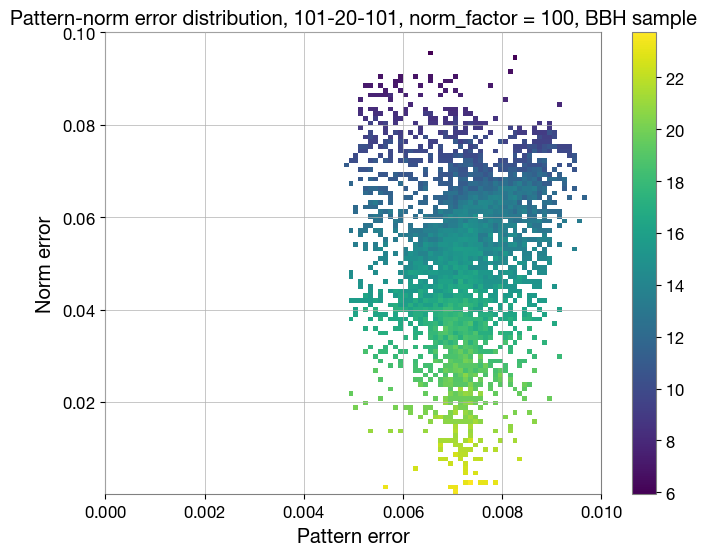

In [210]:
# 生成随机二维数据
# x = np.random.randn(1000)
# y = np.random.randn(1000)

# 指定直方图箱的数量
bins_x = np.arange(0, 0.01, 1e-4)
# bins_x = np.logspace(-3, -1, 50)
# bins_y = [1e-8, 2e-8, 3e-8, 4e-8, 5e-8, 6e-8, 7e-8, 8e-8, 9e-8, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7, 8e-7, 9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1]
bins_y = np.logspace(-9, -1, 100)

# 计算二维直方图的统计数据
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_injected_output_100d,ReconstructedError_injected_output_1d, bins=[bins_x, bins_y], density='True')
hist = np.log(hist)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 100, BBH sample')
plt.xlabel('Pattern error')
plt.ylabel('Norm error')
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, 0.01)

# 显示图形
plt.show()

/var/folders/2v/3ndz_6mx79z7p4z3mfgc3kvc0000gn/T/ipykernel_51181/1366737112.py:13: RuntimeWarning: divide by zero encountered in log
  hist = np.log(hist)


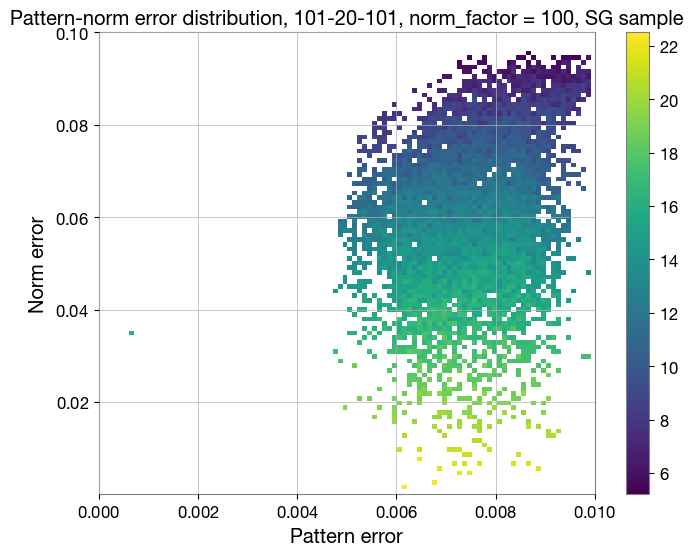

In [213]:
# 生成随机二维数据
# x = np.random.randn(1000)
# y = np.random.randn(1000)

# 指定直方图箱的数量
bins_x = np.arange(0, 0.01, 1e-4)
# bins_x = np.logspace(-3, -1, 50)
# bins_y = [1e-8, 2e-8, 3e-8, 4e-8, 5e-8, 6e-8, 7e-8, 8e-8, 9e-8, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7, 8e-7, 9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1]
bins_y = np.logspace(-9, -1, 100)

# 计算二维直方图的统计数据
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_sinegaussian_output_100d,ReconstructedError_sinegaussian_output_1d, bins=[bins_x, bins_y], density='True')
hist = np.log(hist)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 100, SG sample')
plt.xlabel('Pattern error')
plt.ylabel('Norm error')
plt.xscale('linear')
plt.yscale('linear')
plt.xlim(0, 0.01)

# 显示图形
plt.show()

/var/folders/2v/3ndz_6mx79z7p4z3mfgc3kvc0000gn/T/ipykernel_51181/2174872979.py:13: RuntimeWarning: divide by zero encountered in log
  hist = np.log(hist)


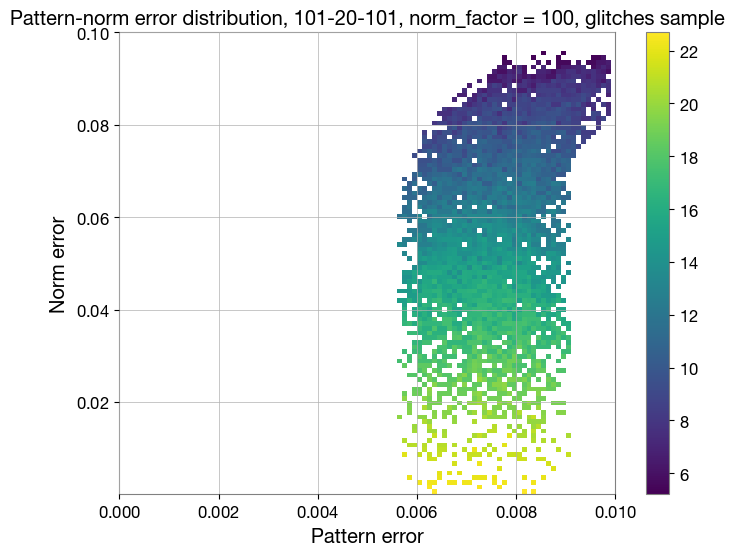

In [217]:
# 生成随机二维数据
# x = np.random.randn(1000)
# y = np.random.randn(1000)

# 指定直方图箱的数量
bins_x = np.arange(0, 0.01, 1e-4)
# bins_x = np.logspace(-3, -1, 50)
# bins_y = [1e-8, 2e-8, 3e-8, 4e-8, 5e-8, 6e-8, 7e-8, 8e-8, 9e-8, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7, 8e-7, 9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1]
bins_y = np.logspace(-9, -1, 100)

# 计算二维直方图的统计数据
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_glitches_output_100d,ReconstructedError_glitches_output_1d, bins=[bins_x, bins_y], density='True')
hist = np.log(hist)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 100, glitches sample')
plt.xlabel('Pattern error')
plt.ylabel('Norm error')
plt.xscale('linear')
plt.yscale('linear')
plt.xlim(0, 0.01)

# 显示图形
plt.show()

In [229]:
data_bunch_noise = np.load("../Data_cached/4000Hz25msnoisesample1e6.npy") * 1e21
data_bunch_noise_normalized, _, data_bunch_noise_norm = bunch_normalization(data_bunch_noise)
data_bunch_noise_input = np.hstack((data_bunch_noise_normalized, np.array(data_bunch_noise_norm).reshape(len(data_bunch_noise_normalized), 1)))

In [311]:
del data_bunch_noise, data_bunch_noise_input, data_bunch_noise_norm, data_bunch_noise_normalized

In [230]:
np.linalg.norm(data_bunch_noise, axis = 1).mean()

0.32893217367970656

In [231]:
data_bunch_noise_tensored = torch.FloatTensor(data_bunch_noise_input)
_, decodedTestdata = autoencoder(data_bunch_noise_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_bunch_noise = decodedTestdata.detach().numpy()
ReconstructedError_bunch_noise_100d = np.mean((data_bunch_noise_tensored.numpy()[:,:100] - reconstructedData_bunch_noise[:,:100])**2,axis=1)
ReconstructedError_bunch_noise_1d = (data_bunch_noise_tensored.numpy()[:,-1] - reconstructedData_bunch_noise[:,-1])**2
MSE_bunch_noise_100d = ReconstructedError_bunch_noise_100d.mean()
MSE_bunch_noise_1d = ReconstructedError_bunch_noise_1d.mean()

/var/folders/2v/3ndz_6mx79z7p4z3mfgc3kvc0000gn/T/ipykernel_51181/1390263505.py:13: RuntimeWarning: divide by zero encountered in log
  hist_bunch_noise = np.log(hist)


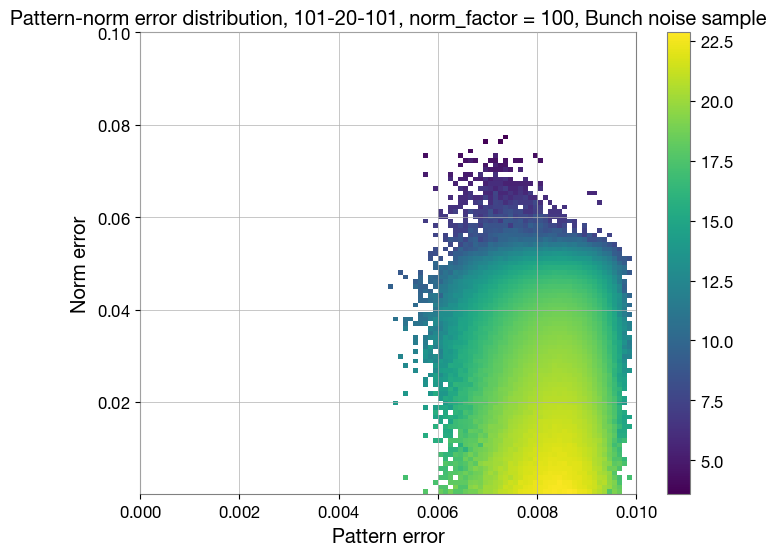

In [273]:
# 生成随机二维数据
# x = np.random.randn(1000)
# y = np.random.randn(1000)

# 指定直方图箱的数量
bins_x = np.arange(0, 0.01, 1e-4)
# bins_x = np.logspace(-3, -1, 50)
# bins_y = [1e-8, 2e-8, 3e-8, 4e-8, 5e-8, 6e-8, 7e-8, 8e-8, 9e-8, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7, 8e-7, 9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1]
bins_y = np.logspace(-9, -1, 100)

# 计算二维直方图的统计数据
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_bunch_noise_100d,ReconstructedError_bunch_noise_1d, bins=[bins_x, bins_y], density='True')
hist_bunch_noise = np.log(hist)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist_bunch_noise.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 100, Bunch noise sample')
plt.xlabel('Pattern error')
plt.ylabel('Norm error')
plt.xscale('linear')
plt.yscale('linear')
plt.xlim(0, 0.01)

# 显示图形
plt.show()

In [247]:
bunch_noise_hist = hist.flatten()

In [248]:
bunch_noise_hist = np.sort(bunch_noise_hist)

In [249]:
print(bunch_noise_hist)

[       -inf        -inf        -inf ... 22.71516141 22.72867513
 22.84869281]


In [254]:
threshold = 0.05 * len(data_bunch_noise)
sum = 0
i=0
while(sum < threshold):
    sum += 10 ** bunch_noise_hist[i]
    i += 1 
    
bunch_noise_hist[i]

4.327870104867369

In [255]:
sum

50737.689394174144

In [269]:
def set_values_less_than(arr, value):
    arr[arr < value] = -np.inf
    return arr

hist_FPR_005 = set_values_less_than(hist, bunch_noise_hist[i])

In [270]:
hist_FPR_005

array([[-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       ...,
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf]])

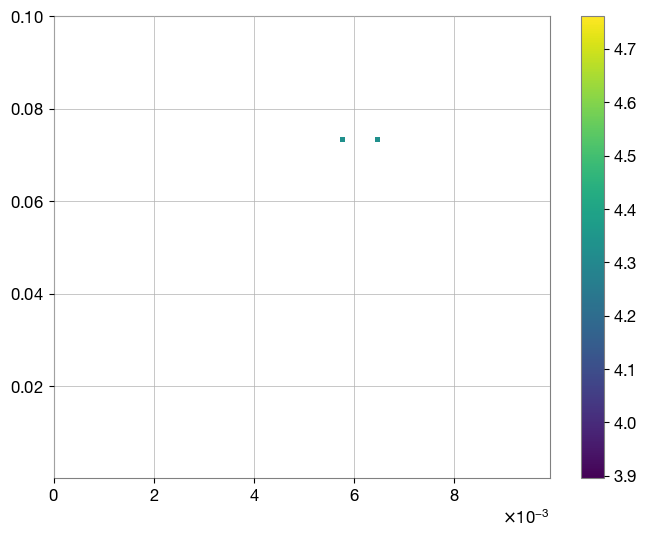

In [271]:
plt.figure(figsize=(8, 6)) 
plt.imshow(hist_FPR_005.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

In [275]:
mask = np.argwhere(hist_bunch_noise != -np.inf)

In [299]:
def hist_mask(hist, mask):
    sum = (10**hist).sum()
    mask_Boolen = np.zeros((len(hist), len(hist)), dtype=bool)
    mask_Boolen[mask[:, 0], mask[:, 1]] = True
    hist[mask_Boolen] = -np.inf
    sum_masked = (10**hist).sum()
    TPR = sum_masked/sum
    return hist,TPR

In [288]:
mask[:,0].shape

(2437,)

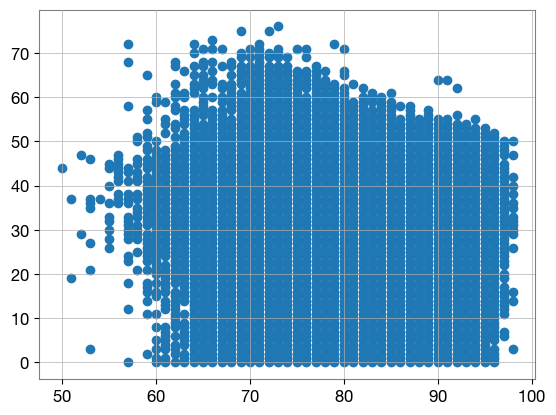

In [289]:
plt.scatter(mask[:,0], mask[:,1])

0.0


/var/folders/2v/3ndz_6mx79z7p4z3mfgc3kvc0000gn/T/ipykernel_51181/550919298.py:14: RuntimeWarning: divide by zero encountered in log
  hist = np.log(hist)


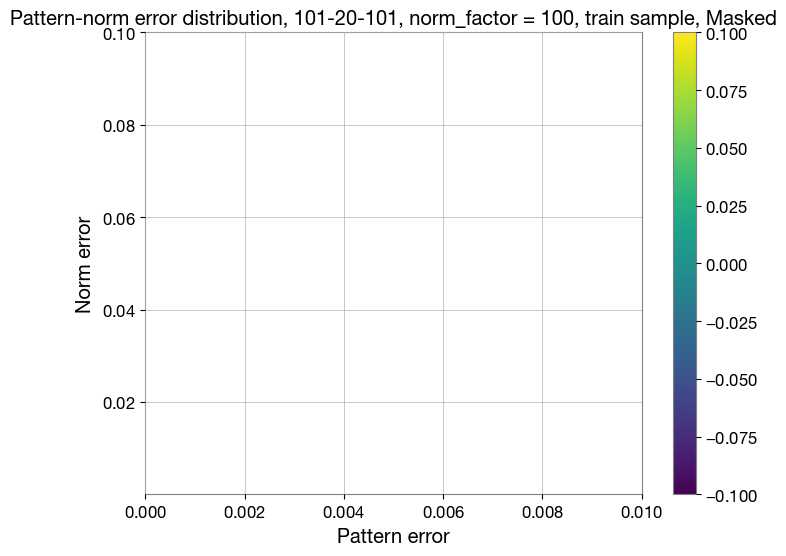

In [303]:
# 生成随机二维数据
# x = np.random.randn(1000)
# y = np.random.randn(1000)

# 指定直方图箱的数量
bins_x = np.arange(0, 0.01, 1e-4)
# bins_x = np.logspace(-3, -1, 50)
# bins_y = [1e-8, 2e-8, 3e-8, 4e-8, 5e-8, 6e-8, 7e-8, 8e-8, 9e-8, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7, 8e-7, 9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1]
bins_y = np.logspace(-9, -1, 100)


# 计算二维直方图的统计数据
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_train_output_100d,ReconstructedError_train_output_1d, bins=[bins_x, bins_y], density='True')
hist = np.log(hist)
hist, TPR = hist_mask(hist, mask)
print(TPR)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 100, train sample, Masked')
plt.xlabel('Pattern error')
plt.ylabel('Norm error')
plt.xscale('linear')
plt.yscale('linear')
plt.xlim(0, 0.01)

# 显示图形
plt.show()

0.0


/var/folders/2v/3ndz_6mx79z7p4z3mfgc3kvc0000gn/T/ipykernel_51181/2113573846.py:13: RuntimeWarning: divide by zero encountered in log
  hist = np.log(hist)


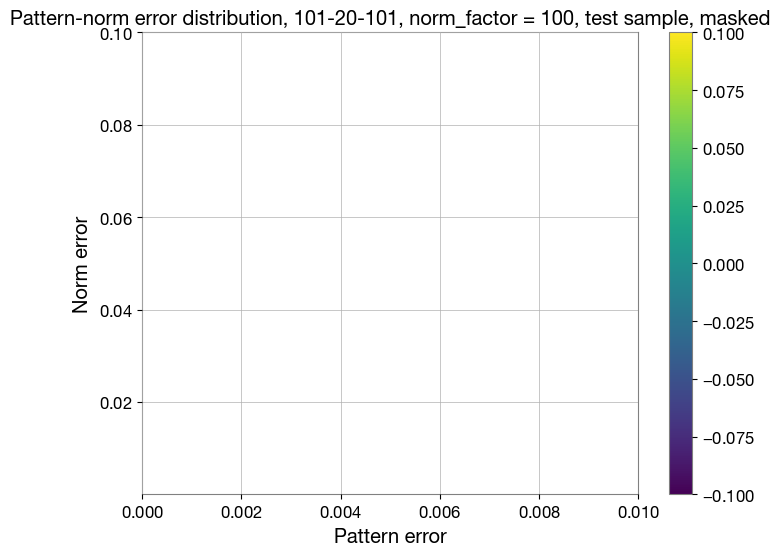

In [302]:
# 生成随机二维数据
# x = np.random.randn(1000)
# y = np.random.randn(1000)

# 指定直方图箱的数量
bins_x = np.arange(0, 0.01, 1e-4)
# bins_x = np.logspace(-3, -1, 50)
# bins_y = [1e-8, 2e-8, 3e-8, 4e-8, 5e-8, 6e-8, 7e-8, 8e-8, 9e-8, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7, 8e-7, 9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1]
bins_y = np.logspace(-9, -1, 100)

# 计算二维直方图的统计数据
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_test_output_100d,ReconstructedError_test_output_1d, bins=[bins_x, bins_y], density='True')
hist = np.log(hist)
hist, TPR = hist_mask(hist, mask)
print(TPR)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 100, test sample, masked')
plt.xlabel('Pattern error')
plt.ylabel('Norm error')
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, 0.01)

# 显示图形
plt.show()

0.09050428323241806


/var/folders/2v/3ndz_6mx79z7p4z3mfgc3kvc0000gn/T/ipykernel_51181/490504450.py:13: RuntimeWarning: divide by zero encountered in log
  hist = np.log(hist)


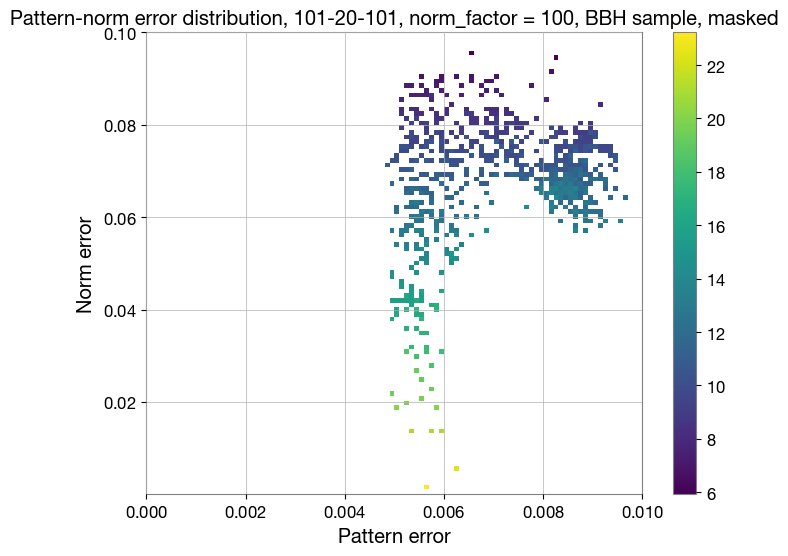

In [300]:
# 生成随机二维数据
# x = np.random.randn(1000)
# y = np.random.randn(1000)

# 指定直方图箱的数量
bins_x = np.arange(0, 0.01, 1e-4)
# bins_x = np.logspace(-3, -1, 50)
# bins_y = [1e-8, 2e-8, 3e-8, 4e-8, 5e-8, 6e-8, 7e-8, 8e-8, 9e-8, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7, 8e-7, 9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1]
bins_y = np.logspace(-9, -1, 100)

# 计算二维直方图的统计数据
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_injected_output_100d,ReconstructedError_injected_output_1d, bins=[bins_x, bins_y], density='True')
hist = np.log(hist)
hist, TPR = hist_mask(hist, mask)
print(TPR)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 100, BBH sample, masked')
plt.xlabel('Pattern error')
plt.ylabel('Norm error')
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, 0.01)

# 显示图形
plt.show()

0.009621487521436042


/var/folders/2v/3ndz_6mx79z7p4z3mfgc3kvc0000gn/T/ipykernel_51181/3229434540.py:13: RuntimeWarning: divide by zero encountered in log
  hist = np.log(hist)


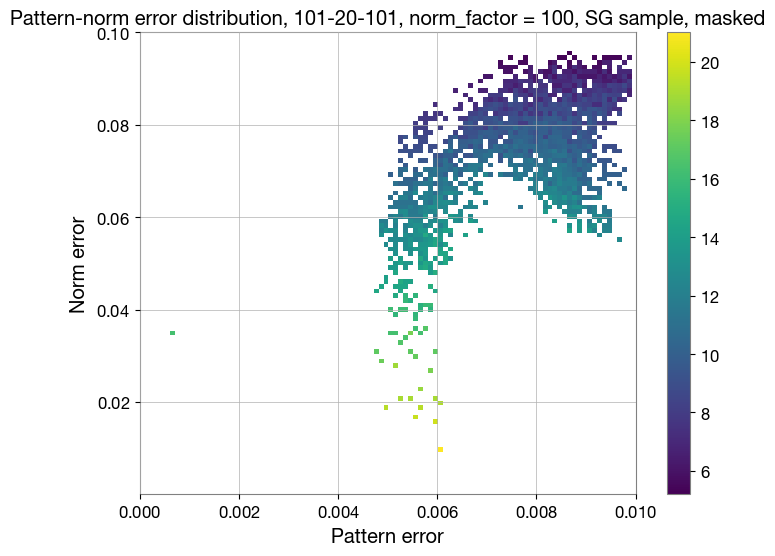

In [301]:
# 生成随机二维数据
# x = np.random.randn(1000)
# y = np.random.randn(1000)

# 指定直方图箱的数量
bins_x = np.arange(0, 0.01, 1e-4)
# bins_x = np.logspace(-3, -1, 50)
# bins_y = [1e-8, 2e-8, 3e-8, 4e-8, 5e-8, 6e-8, 7e-8, 8e-8, 9e-8, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7, 8e-7, 9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1]
bins_y = np.logspace(-9, -1, 100)

# 计算二维直方图的统计数据
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_sinegaussian_output_100d,ReconstructedError_sinegaussian_output_1d, bins=[bins_x, bins_y], density='True')
hist = np.log(hist)
hist, TPR = hist_mask(hist, mask)
print(TPR)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 100, SG sample, masked')
plt.xlabel('Pattern error')
plt.ylabel('Norm error')
plt.xscale('linear')
plt.yscale('linear')
plt.xlim(0, 0.01)

# 显示图形
plt.show()

0.11224390210791295


/var/folders/2v/3ndz_6mx79z7p4z3mfgc3kvc0000gn/T/ipykernel_51181/3684822415.py:13: RuntimeWarning: divide by zero encountered in log
  hist = np.log(hist)


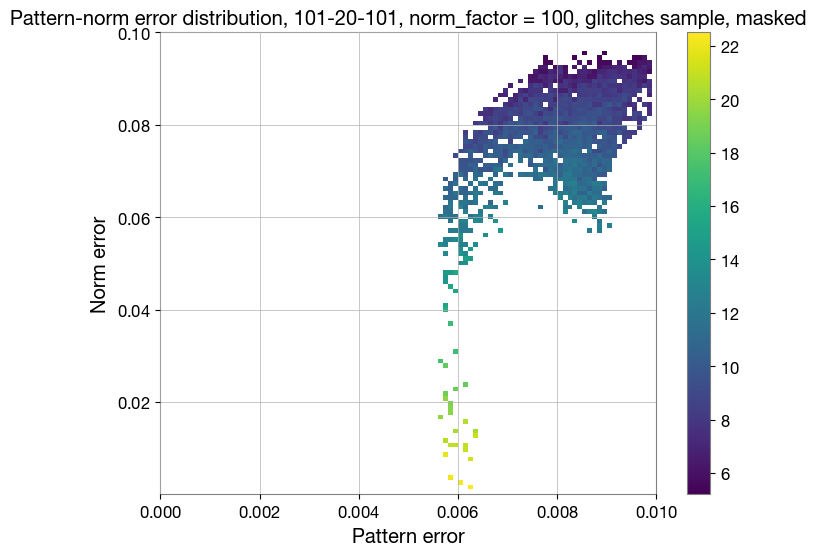

In [304]:
# 生成随机二维数据
# x = np.random.randn(1000)
# y = np.random.randn(1000)

# 指定直方图箱的数量
bins_x = np.arange(0, 0.01, 1e-4)
# bins_x = np.logspace(-3, -1, 50)
# bins_y = [1e-8, 2e-8, 3e-8, 4e-8, 5e-8, 6e-8, 7e-8, 8e-8, 9e-8, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7, 8e-7, 9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1]
bins_y = np.logspace(-9, -1, 100)

# 计算二维直方图的统计数据
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_glitches_output_100d,ReconstructedError_glitches_output_1d, bins=[bins_x, bins_y], density='True')
hist = np.log(hist)
hist, TPR = hist_mask(hist, mask)
print(TPR)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 100, glitches sample, masked')
plt.xlabel('Pattern error')
plt.ylabel('Norm error')
plt.xscale('linear')
plt.yscale('linear')
plt.xlim(0, 0.01)

# 显示图形
plt.show()